### === **Whale Optimization Algorithm (WOA) for Feature Selection to optimize feature subsets for various ML classifiers** ===

-----------------------------------------------------------------------------------------------

**1. Stable Feature Pre-selection:**

* Performed initial feature selection using **bootstrapped LASSO logistic regression** (`penalty='l1'`, `solver='liblinear'`, `cv=5`, `max_iter=5000`), repeated for **100 bootstrap samples** (`n_bootstrap=100`). Features were retained if selected in **≥70%** of bootstraps (`freq_threshold=0.7`), ensuring stability against sampling variance.


**2. Metaheuristic Feature Selection:**

* Applies **Particle Swarm Optimization (PSO)** for further feature selection from the stable set, using a population of **20 particles** (`n_particles=20`) and **50 iterations** (`max_iter=50`). Each particle represented a binary feature mask, and the swarm was optimized to maximize mean ROC AUC over 5-fold stratified cross-validation (`StratifiedKFold(n_splits=5, shuffle=True, random_state=42)`).


**3. Comprehensive Classifier Comparison:**

* Evaluated a broad suite of classifiers:

  * **Logistic Regression** (`max_iter=1000`), with grid search over `C=[0.001, 0.01, 0.1, 1, 10]` and `penalty=['l1', 'l2']`

  * **Gaussian Naive Bayes** (default parameters)

  * **Support Vector Machines** (linear and RBF kernels, `C=[0.01, 0.1, 1, 10]`, `gamma=['scale', 'auto']`)

  * **Decision Tree** (`max_depth=[3, 5, 7]`, `min_samples_split=[5, 10]`, `min_samples_leaf=[2, 4]`)

  * **Random Forest** (`n_estimators=[100, 200]`, `max_depth=[5, 10]`, `min_samples_split=[5, 10]`, `min_samples_leaf=[2, 4]`)

  * **VotingClassifier** ensemble combining top-tuned base models with soft voting.

* Hyperparameters were tuned for each classifier using **GridSearchCV** and 5-fold stratified cross-validation, optimizing for ROC AUC.


**4. Class Imbalance and Data Integrity Handling:**

* Maintained **class distribution balance** in all data splits using stratified sampling, both in train/test partitioning (`test_size=0.2`) and during cross-validation.

* For bootstrapping and CI estimation, ensured that each resample included both classes—skipping samples otherwise to avoid invalid AUC calculations.


**5. Feature Scaling and Pipeline Safety:**

* Applied **feature standardization** (`StandardScaler()`) within all pipelines, fitting scalers only on training data to prevent information leakage.

* Model pipelines (`make_pipeline(StandardScaler(), classifier)`) ensured consistent preprocessing during evaluation and prediction.


**6. Model Evaluation & Uncertainty Quantification:**

* Reported **ROC AUC and accuracy** for both training and testing sets at each PSO iteration.

* Computed **bootstrapped confidence intervals** for test AUC (`n_bootstrap=1000`, `ci=0.95`), resampling test predictions to quantify model uncertainty and generalization performance.


**7. Visualization and Monitoring:**

* Plotted **train/test AUC trends** across PSO iterations for convergence analysis.

* Displayed final **ROC curves** for both training and testing sets, including mean AUC and 95% confidence intervals.


---

##### === IMPORTS ===

In [12]:
import numpy as np                                                                            # Core numerical computation library for arrays and matrix operations
import pandas as pd                                                                           # Library for data manipulation and analysis (tabular data, DataFrames)
from sklearn.base import clone                                                                # For cloning estimators (useful when building pipelines or doing cross-validation)
import matplotlib.pyplot as plt                                                               # For plotting graphs (e.g., ROC curves, feature importances, etc.)
from scipy.stats import bootstrap                                                             # For statistical bootstrap resampling (scipy's bootstrap is for CI, sklearn's resample for random sampling)
from sklearn.utils import resample                                                            # Utility to randomly resample datasets (e.g., for bootstrapping in ML)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold        # For splitting data, cross-validation, and stratified folds (for imbalanced classes)
from sklearn.preprocessing import StandardScaler                                              # For scaling features to zero mean/unit variance (important for many ML algorithms)
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score                          # For evaluating model performance: ROC AUC, ROC curve points, accuracy

# === CLASSIFIERS ===

from sklearn.naive_bayes import GaussianNB                                                    # Naive Bayes classifier for classification tasks
from sklearn.svm import SVC                                                                   # Support Vector Classifier (linear & nonlinear SVMs)
from sklearn.tree import DecisionTreeClassifier                                               # Decision Tree classifier (nonlinear, interpretable ML model)
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier     # Random Forest classifier (ensemble of Decision Trees)
from sklearn.pipeline import make_pipeline                                                    # For creating machine learning pipelines (combining preprocessing + models)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV                     # Logistic Regression (standard and cross-validated, for classification)

# === GRID SEARCH HYPERPARAMETER TUNING ===

from sklearn.model_selection import GridSearchCV                                              # For exhaustive grid search over hyperparameters with cross-validation

---

##### === LOAD AND PREPROCESS DATA ===

In [13]:
def load_data():
    # Load radiomics and clinical CSV files into DataFrames
    radiomics = pd.read_csv("./HNC-Prospective-Radiomics-305.csv")
    clinical = pd.read_csv("./proceed_radiomics_166.csv")

    print(f"Initial clinical data: {len(clinical)} patients")
    # print(f"Unique locations in clinical data: {clinical['Location'].value_counts()}")

    # Filter clinical data to only include specific tumor locations
    # clinical = clinical[clinical["Location"].isin(['Larynx', 'Tonsil', 'Hypopharynx', 'Oropharynx', 'BOT', 'Other'])]
    # print(f"After location filtering: {len(clinical)} patients")

    # Standardize 'research_subject_uid' in radiomics by keeping only the part before "_"
    radiomics["research_subject_uid"] = radiomics["research_subject_uid"].apply(lambda x: x.split("_")[0])

    # Remove any leading/trailing spaces from 'Project ID' in clinical data
    clinical["Project ID"] = clinical["Project ID"].str.strip()

    # Filter radiomics to only keep rows with research_subject_uid present in clinical Project IDs
    radiomics_filtered = radiomics[radiomics["research_subject_uid"].isin(clinical["Project ID"])]
    
    # Filter clinical to only keep rows with Project ID present in radiomics research_subject_uid
    clinical_filtered = clinical[clinical["Project ID"].isin(radiomics["research_subject_uid"])]

    print(f"Final matched data: {len(clinical_filtered)} patients")

    # Sort both DataFrames by their ID columns and reset their indices
    radiomics_filtered = radiomics_filtered.sort_values(by="research_subject_uid").reset_index(drop=True)
    clinical_filtered = clinical_filtered.sort_values(by="Project ID").reset_index(drop=True)

    # Return the filtered and aligned DataFrames for further processing
    return radiomics_filtered, clinical_filtered


def get_radiomics_columns(data):
    """
    Returns the columns from 'original_shape_Elongation' to 'original_ngtdm_Strength'.
    These typically represent the set of radiomics features you want to extract.
    """
    start_column = "original_shape_Elongation"
    end_column = "original_ngtdm_Strength"
    start_idx = data.columns.get_loc(start_column)
    end_idx = data.columns.get_loc(end_column) + 1  # +1 to include the end column itself
    return data.columns[start_idx:end_idx]

---

##### === Define hyperparameter grids for each classifier ===

In [14]:
# These grids help tune the model to avoid overfitting by optimizing regularization and other key parameters.
all_grid_params = {
    'LogisticRegression': {
        'C': [1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3, 1, 3, 10],          # Regularization strength (lower = stronger regularization)
        'penalty': ['l1', 'l2'],                                                # Type of regularization: L1 (Lasso), L2 (Ridge)
        'solver': ['liblinear'],                                                # Solver that supports both l1 and l2
        'class_weight': [None, "balanced"],
        'max_iter': [1000],
    },
    'GaussianNB': {},                                                           # No tunable hyperparameters for basic Naive Bayes
    'SVC': [
        # Linear SVC
        {
            'C': [1e-3, 1e-2, 0.1, 1, 10],                                      # Regularization strength
            'kernel': ['linear'],                                               # Linear kernel
            'probability': [True],                                              # Needed for probability predictions (e.g., ROC AUC)
            'class_weight': [None, "balanced"],
        },
        # RBF SVC
        {
            'C': [1e-3, 1e-2, 0.1, 1, 10],                                      # Regularization strength
            'gamma': ['scale', 'auto', 1e-3, 1e-2, 1e-1],                       # Kernel coefficient for RBF
            'kernel': ['rbf'],                                                  # RBF (nonlinear) kernel
            'probability': [True],                                              # Probability estimates
            'class_weight': [None, "balanced"],
        }
    ],
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],                                       # Split quality metric
        'max_depth': [2, 3, 4, 5, 7],                                           # Controls tree depth (regularization)
        'min_samples_split': [5, 10, 15],                                       # Minimum samples required to split a node
        'min_samples_leaf': [2, 4, 6],                                          # Minimum samples per leaf node
        'max_features': ['sqrt', 'log2', None],                                 # Number of features considered at each split
        'class_weight': [None, "balanced"],
        'random_state': [42],
    },
    'RandomForestClassifier': {
        'n_estimators': [100, 200, 400],                                        # Number of trees
        'max_depth': [3, 5, 7, 10],                                             # Maximum depth of trees
        'min_samples_split': [5, 10],                                           # Minimum samples to split an internal node
        'min_samples_leaf': [2, 4],                                             # Minimum samples at a leaf node
        'max_features': ['sqrt', 'log2'],                                       # Number of features considered at each split
        'bootstrap': [True],                                                    # Use bootstrap samples
        'n_jobs': [-1],                                                         # Use all available CPU cores for parallel processing
        'class_weight': [None, "balanced", "balanced_subsample"],
        'random_state': [42],
    },
}


# === Utility function to tune a classifier's hyperparameters using grid search and cross-validation ===

def get_tuned_model(classifier, X_train, y_train):
    name = classifier.__class__.__name__                                 # Get class name as a string (e.g., 'LogisticRegression')
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)      # 5-fold stratified cross-validation
    
    # Special handling for SVC as its grid is a list (to support both linear & RBF kernels)
    if name == 'SVC':
        grid = GridSearchCV(
            clone(classifier),            # Clone base estimator to avoid data leakage between folds
            all_grid_params['SVC'],
            scoring='roc_auc',            # Use ROC AUC for model selection (works for imbalanced data)
            cv=cv,                        # Use stratified k-fold
            n_jobs=-1,                    # Use all CPU cores
            refit=True,
        )
        grid.fit(X_train, y_train)       # Fit grid search
        return grid.best_estimator_      # Return the model with best hyperparameters

    # For all other classifiers with defined grid parameters
    elif name in all_grid_params and all_grid_params[name]:
        grid = GridSearchCV(
            clone(classifier),
            all_grid_params[name],
            scoring='roc_auc',
            cv=cv,
            n_jobs=-1,
            refit=True,
        )
        grid.fit(X_train, y_train)
        return grid.best_estimator_

    # If no hyperparameters to tune (e.g., GaussianNB), return the original classifier
    return classifier

---

##### === BOOTSTRAP LASSO FEATURE SELECTION ===

In [ ]:
def bootstrap_lasso_fs(X, y, n_bootstrap=1000, freq_threshold=0.5, random_state=42):
    """
    Selects stable features using bootstrapped Lasso logistic regression.
    - X: feature matrix (numpy array)
    - y: target labels
    - n_bootstrap: number of bootstrap samples to draw
    - freq_threshold: minimum frequency for a feature to be considered stable
    - random_state: for reproducibility

    Returns the indices of stable features.
    """
    np.random.seed(random_state)
    selected_counts = np.zeros(X.shape[1])  # To count selection frequency for each feature

    for i in range(n_bootstrap):
        # Resample data with replacement (bootstrapping), stratified by class
        X_resampled, y_resampled = resample(X, y, stratify=y, random_state=random_state+i)
        # L1-penalized logistic regression with cross-validation for feature selection
        model = LogisticRegressionCV(
            penalty='l1',
            solver='saga', # 'saga' supports L1 penalty and is efficient for large datasets
            cv=5,
            scoring='roc_auc',
            max_iter=10000,  # Even more iterations
            tol=1e-3,        # More relaxed tolerance
            random_state=random_state+i
        ).fit(X_resampled, y_resampled)
        # Count features selected (non-zero coefficient means selected)
        selected_counts += (model.coef_[0] != 0).astype(int)

    # Calculate frequency of each feature being selected across bootstraps
    selected_frequency = selected_counts / n_bootstrap
    # Select features whose selection frequency >= threshold
    stable_features_idx = np.where(selected_frequency >= freq_threshold)[0]

    print(f"Stable features (freq >= {freq_threshold}): {stable_features_idx}")
    return stable_features_idx

---

##### === WOA Feature Selection ===

In [16]:
def evaluate_fitness(particle, X_train, y_train, model, random_state=42):
    """
    CORRECTED: Evaluates fitness using FRESH CV splits each time.
    Same fix as PSO - creates new StratifiedKFold for each evaluation.
    
    Parameters:
    - particle: binary array (1 = feature selected)
    - X_train: training feature matrix
    - y_train: training labels
    - model: sklearn-compatible classifier
    - random_state: for reproducible CV splits

    Returns: Mean ROC AUC from cross-validation on selected features.
    """
    selected_features = np.count_nonzero(particle)
    
    # Handle edge cases
    if selected_features == 0:
        return 0.0
    elif selected_features == 1:
        return 0.5  # Single feature rarely gives good AUC
    elif selected_features == X_train.shape[1]:
        return 0.6  # Penalize selecting all features
    
    # Select features and evaluate
    X_selected = X_train[:, particle == 1]
    
    try:
        # CRITICAL FIX: Create FRESH CV splits each time (same as PSO fix)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        
        auc_scores = cross_val_score(
            clone(model), X_selected, y_train, 
            cv=cv, scoring='roc_auc', n_jobs=1
        )
        
        # Check for invalid scores
        if np.any(np.isnan(auc_scores)) or len(auc_scores) == 0:
            return 0.0
            
        return np.mean(auc_scores)
        
    except Exception as e:
        print(f"Warning: CV failed for {selected_features} features: {e}")
        return 0.0

In [17]:
def sigmoid_transfer(x):
    """Transfer function to convert continuous values to binary probabilities."""
    return 1 / (1 + np.exp(-10 * (x - 0.5)))  # Steeper sigmoid centered at 0.5

---

##### === WOA Model for Feature Selection ===

In [18]:
# ==========================================
# CORRECTED RUN_WOA FUNCTION
# ==========================================

def run_woa(X_train, y_train, X_val, y_val, model, 
           n_whales=20, max_iter=50, spiral_prob=0.5, b=1, verbose=True):
    """
    CORRECTED Whale Optimization Algorithm for feature selection.
    
    CRITICAL FIXES:
    1. Fixed parameter names: X_test → X_val, y_test → y_val
    2. Uses corrected evaluate_fitness with fresh CV splits
    3. Proper random state management
    4. Enhanced error handling and progress tracking
    
    Parameters:
    - X_train, X_val: Feature matrices (training and validation)
    - y_train, y_val: Target labels (training and validation)
    - model: Classifier to evaluate feature subsets
    - n_whales: Population size
    - max_iter: Maximum iterations
    - spiral_prob: Probability of using spiral bubble-net attack
    - b: Spiral shape parameter
    - verbose: Print progress updates
    
    Returns:
    - best_whale: Binary array of selected features
    - train_scores: Training AUC scores per iteration
    - val_scores: Validation AUC scores per iteration
    """
    
    def compute_auc_scores(X_train_sel, X_val_sel):
        """Compute AUC scores for selected features on train and validation sets."""
        temp_model = clone(model)
        temp_model.fit(X_train_sel, y_train)
        
        # Get probabilities or decision scores
        if hasattr(temp_model, 'predict_proba'):
            y_train_proba = temp_model.predict_proba(X_train_sel)[:, 1]
            y_val_proba = temp_model.predict_proba(X_val_sel)[:, 1]
        else:
            y_train_proba = temp_model.decision_function(X_train_sel)
            y_val_proba = temp_model.decision_function(X_val_sel)
        
        train_auc = roc_auc_score(y_train, y_train_proba)
        val_auc = roc_auc_score(y_val, y_val_proba)
        return train_auc, val_auc

    def plot_convergence(train_scores, val_scores, best_fitness_history):
        """Plot WOA convergence and AUC scores."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot AUC scores over iterations
        valid_iterations = [i for i, (tr, val) in enumerate(zip(train_scores, val_scores)) 
                          if tr is not None and val is not None]
        valid_train = [train_scores[i] for i in valid_iterations]
        valid_val = [val_scores[i] for i in valid_iterations]
        
        if valid_train and valid_val:
            ax1.plot([i+1 for i in valid_iterations], valid_train, 
                    label="Train AUC", marker='o', linewidth=2)
            ax1.plot([i+1 for i in valid_iterations], valid_val, 
                    label="Validation AUC", marker='x', linewidth=2)
            ax1.set_xlabel('Iteration')
            ax1.set_ylabel('AUC Score')
            ax1.set_title('Train vs Validation AUC over WOA Iterations')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
        
        # Plot best fitness convergence
        ax2.plot(range(1, len(best_fitness_history)+1), best_fitness_history, 
                'r-', marker='s', linewidth=2, markersize=4)
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Best Fitness (CV AUC)')
        ax2.set_title('WOA Convergence - Best Fitness')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    def compute_bootstrap_ci(scores, label):
        """Compute bootstrap confidence intervals."""
        if not scores:
            return None
        
        try:
            ci = bootstrap((np.array(scores),), np.mean, 
                         confidence_level=0.95, random_state=42)
            if verbose:
                print(f"{label} AUC Mean: {np.mean(scores):.4f}")
                print(f"95% CI for {label} AUC: [{ci.confidence_interval.low:.4f}, "
                      f"{ci.confidence_interval.high:.4f}]")
            return ci
        except Exception as e:
            if verbose:
                print(f"Warning: Could not compute CI for {label}: {e}")
            return None

    def plot_roc_curve(X_train_sel, X_val_sel, ci_train, ci_val, 
                      train_auc_mean, val_auc_mean):
        """Plot ROC curves for final selected features."""
        final_model = clone(model)
        final_model.fit(X_train_sel, y_train)

        if hasattr(final_model, 'predict_proba'):
            y_train_proba = final_model.predict_proba(X_train_sel)[:, 1]
            y_val_proba = final_model.predict_proba(X_val_sel)[:, 1]
        else:
            y_train_proba = final_model.decision_function(X_train_sel)
            y_val_proba = final_model.decision_function(X_val_sel)

        fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
        fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)

        plt.figure(figsize=(8, 6))
        
        if ci_train and ci_val:
            train_label = (f"Train ROC (95% CI): {train_auc_mean:.3f} "
                          f"({ci_train.confidence_interval.low:.3f}-"
                          f"{ci_train.confidence_interval.high:.3f})")
            val_label = (f"Validation ROC (95% CI): {val_auc_mean:.3f} "
                        f"({ci_val.confidence_interval.low:.3f}-"
                        f"{ci_val.confidence_interval.high:.3f})")
        else:
            train_label = f"Train ROC: {train_auc_mean:.3f}"
            val_label = f"Validation ROC: {val_auc_mean:.3f}"
        
        plt.plot(fpr_train, tpr_train, label=train_label, color='blue', linewidth=2)
        plt.plot(fpr_val, tpr_val, label=val_label, color='orange', linewidth=2)
        plt.plot([0, 1], [0, 1], linestyle='--', color='black', alpha=0.5)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve with WOA-selected Features')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Initialize WOA parameters
    n_features = X_train.shape[1]
    
    # Initialize whales in continuous space [0,1]
    whales = np.random.rand(n_whales, n_features)
    
    # Convert to binary and find initial best whale
    binary_whales = (whales > 0.5).astype(int)
    best_whale = binary_whales[0].copy()
    best_score = evaluate_fitness(best_whale, X_train, y_train, model, random_state=42)
    
    # CORRECTED: Find actual best whale in initial population with unique random states
    for i in range(n_whales):
        score = evaluate_fitness(binary_whales[i], X_train, y_train, model, random_state=42+i)
        if score > best_score:
            best_score = score
            best_whale = binary_whales[i].copy()
    
    # Tracking variables
    train_scores, val_scores = [], []
    best_fitness_history = []
    no_improvement_count = 0
    
    if verbose:
        print(f"Starting WOA with {n_whales} whales, {max_iter} iterations")
        print(f"Initial best fitness: {best_score:.4f}")
    
    # WOA main loop
    for iteration in range(max_iter):
        # Linearly decreasing parameter a from 2 to 0
        a = 2 * (1 - iteration / max_iter)
        
        improved = False
        for i in range(n_whales):
            # Random parameters for WOA
            r1, r2 = np.random.rand(), np.random.rand()
            A = 2 * a * r1 - a  # Coefficient vector A
            C = 2 * r2           # Coefficient vector C
            
            # Choose between encircling prey or spiral bubble-net attack
            if np.random.rand() < spiral_prob:
                # Spiral bubble-net attacking method
                best_whale_continuous = best_whale.astype(float)
                distance = np.abs(best_whale_continuous - whales[i])
                l = np.random.uniform(-1, 1, n_features)
                
                # Spiral equation: X(t+1) = D' * e^(bl) * cos(2πl) + X*(t)
                spiral_term = distance * np.exp(b * l) * np.cos(2 * np.pi * l)
                whales[i] = best_whale_continuous + spiral_term
                
            else:
                if np.abs(A) < 1:
                    # Encircling prey (exploitation phase)
                    best_whale_continuous = best_whale.astype(float)
                    D = np.abs(C * best_whale_continuous - whales[i])
                    whales[i] = best_whale_continuous - A * D
                    
                else:
                    # Search for prey (exploration phase)
                    rand_whale_idx = np.random.randint(0, n_whales)
                    rand_whale = binary_whales[rand_whale_idx].astype(float)
                    D = np.abs(C * rand_whale - whales[i])
                    whales[i] = rand_whale - A * D
            
            # Boundary control - keep whales in [0,1]
            whales[i] = np.clip(whales[i], 0, 1)
            
            # Convert to binary using sigmoid transfer function
            binary_prob = sigmoid_transfer(whales[i])
            binary_whales[i] = (np.random.rand(n_features) < binary_prob).astype(int)
            
            # Ensure at least one feature is selected
            if np.sum(binary_whales[i]) == 0:
                binary_whales[i][np.random.randint(0, n_features)] = 1
            
            # CRITICAL: Evaluate fitness with unique random state for fresh CV splits
            current_score = evaluate_fitness(
                binary_whales[i], X_train, y_train, model, 
                random_state=42 + iteration * n_whales + i
            )
            
            if current_score > best_score:
                best_score = current_score
                best_whale = binary_whales[i].copy()
                improved = True
                no_improvement_count = 0
        
        if not improved:
            no_improvement_count += 1
            
        # Track best fitness
        best_fitness_history.append(best_score)
        
        # Compute AUC scores for current best whale on train and validation sets
        if np.count_nonzero(best_whale) > 0:
            X_train_sel = X_train[:, best_whale == 1]
            X_val_sel = X_val[:, best_whale == 1]
            try:
                train_auc, val_auc = compute_auc_scores(X_train_sel, X_val_sel)
                train_scores.append(train_auc)
                val_scores.append(val_auc)
            except Exception as e:
                if verbose:
                    print(f"Warning: Could not compute AUC at iteration {iteration+1}: {e}")
                train_scores.append(None)
                val_scores.append(None)
        else:
            train_scores.append(None)
            val_scores.append(None)
        
        # Progress reporting
        if verbose and (iteration + 1) % 10 == 0:
            n_selected = np.sum(best_whale)
            print(f"Iteration {iteration+1}/{max_iter}: "
                  f"Best fitness = {best_score:.4f}, "
                  f"Features selected = {n_selected}")
        
        # Early stopping if no improvement for too long
        if no_improvement_count > max_iter // 3:
            if verbose:
                print(f"Early stopping at iteration {iteration+1} due to no improvement")
            break
    
    # Final results
    n_selected = np.sum(best_whale)
    selected_indices = np.where(best_whale)[0].tolist()
    
    if verbose:
        print(f"\n=== WOA Feature Selection Results ===")
        print(f"Final best fitness (CV AUC): {best_score:.4f}")
        print(f"Selected features count: {n_selected}")
        print(f"Selected feature indices: {selected_indices}")
    
    # Plot convergence
    plot_convergence(train_scores, val_scores, best_fitness_history)
    
    # Compute bootstrap confidence intervals
    valid_train_scores = [s for s in train_scores if s is not None]
    valid_val_scores = [s for s in val_scores if s is not None]
    
    ci_train = compute_bootstrap_ci(valid_train_scores, "Train")
    ci_val = compute_bootstrap_ci(valid_val_scores, "Validation")
    
    # Plot ROC curve for final model
    if n_selected > 0 and ci_train and ci_val:
        X_train_final = X_train[:, best_whale == 1]
        X_val_final = X_val[:, best_whale == 1]
        plot_roc_curve(
            X_train_final, X_val_final,
            ci_train, ci_val,
            np.mean(valid_train_scores), np.mean(valid_val_scores)
        )
    
    return best_whale, train_scores, val_scores

---

##### === Evaluate model with classifier function ===

In [19]:
def evaluate_model_with_classifier(X_train, X_test, y_train, y_test, selected_features, feature_names, classifier):
    """
    Trains and evaluates a given classifier using only the features selected by a feature selection algorithm.
    Prints Train/Test AUC and Accuracy.
    
    Parameters:
        X_train, X_test: Feature matrices (numpy arrays)
        y_train, y_test: Labels
        selected_features: Binary vector indicating which features to use
        feature_names: List of feature names (not used here, but useful for further reporting)
        classifier: Classifier instance (e.g., LogisticRegression)
    """
    # Select only the features chosen by the feature selection mask
    X_train_sel = X_train[:, selected_features == 1]
    X_test_sel = X_test[:, selected_features == 1]

    # If no features were selected, print a warning and stop
    if X_train_sel.shape[1] == 0:
        print("\n⚠️ No features selected. Cannot train classifier.")
        return

    # Build pipeline: scale features then fit classifier
    model = make_pipeline(StandardScaler(), classifier)
    model.fit(X_train_sel, y_train)  # Train the model on selected features

    # Get predicted probabilities or decision function for AUC
    y_train_proba = model.predict_proba(X_train_sel)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_train_sel)
    y_test_proba = model.predict_proba(X_test_sel)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test_sel)

    # Get predicted labels for accuracy
    y_train_pred = model.predict(X_train_sel)
    y_test_pred = model.predict(X_test_sel)

    # Print evaluation metrics for train and test sets
    print(f"\n✅ Results for {classifier.__class__.__name__}:")
    print(f"Train AUC: {roc_auc_score(y_train, y_train_proba):.4f}")
    print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Test AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")


---

##### === Computes a bootstrapped confidence interval for ROC AUC of the final model ===

In [20]:
def bootstrap_final_model_auc_ci(
    y_true,
    y_pred_proba,
    n_bootstrap: int = 1000,
    ci: float = 0.95,
    random_state: int = 42,
    min_valid: int = 200,
):
    """
    Stratified bootstrap CI for ROC AUC on small/imbalanced test sets.
    - Preserves class counts in each bootstrap sample (positives/negatives drawn separately).
    - Avoids invalid replicates with a single class.
    - Returns mean AUC and (lower, upper) percentile CI.
    
    Parameters
    ----------
    y_true : array-like
        True binary labels. If not exactly {0,1}, they will be remapped to {0,1} by ordering.
    y_pred_proba : array-like
        Predicted probabilities or decision scores (higher = more likely positive).
    n_bootstrap : int, default=2000
        Number of bootstrap replicates.
    ci : float, default=0.95
        Confidence level (e.g., 0.95 for 95% CI).
    random_state : int, default=42
        Seed for reproducibility.
    min_valid : int, default=200
        Minimum recommended number of valid bootstrap replicates for a stable CI.
    
    Returns
    -------
    mean_auc : float
    lower : float
    upper : float
    valid : int
        Number of valid bootstrap replicates used.
    """

    rng = np.random.default_rng(random_state)

    # Convert to numpy arrays
    y_true = y_true.values if hasattr(y_true, "values") else np.asarray(y_true)
    y_pred_proba = y_pred_proba.values if hasattr(y_pred_proba, "values") else np.asarray(y_pred_proba)

    # Basic checks
    if y_true.shape[0] != y_pred_proba.shape[0]:
        raise ValueError("y_true and y_pred_proba must have the same number of samples.")

    uniq = np.unique(y_true)
    if uniq.size < 2:
        raise ValueError("AUC undefined: test set has a single class.")
    if uniq.size > 2:
        # Remap to binary by ordering (largest label -> positive class)
        # This allows labels like {-1, +1} or {0, 2}
        pos_label = uniq.max()
        y_true = (y_true == pos_label).astype(int)
        uniq = np.array([0, 1])

    # Class counts
    n_pos = int((y_true == 1).sum())
    n_neg = int((y_true == 0).sum())
    if min(n_pos, n_neg) < 3:
        print(f"Warning: very few positives/negatives (pos={n_pos}, neg={n_neg}); CI will be unstable.")

    # Index pools by class
    pos_idx = np.where(y_true == 1)[0]
    neg_idx = np.where(y_true == 0)[0]

    aucs = []
    for _ in range(n_bootstrap):
        # Stratified resample: draw with replacement within each class
        b_pos = rng.choice(pos_idx, size=n_pos, replace=True)
        b_neg = rng.choice(neg_idx, size=n_neg, replace=True)
        b_idx = np.concatenate([b_pos, b_neg])
        rng.shuffle(b_idx)  # order doesn't matter for AUC, but good practice

        try:
            aucs.append(roc_auc_score(y_true[b_idx], y_pred_proba[b_idx]))
        except ValueError:
            # Extremely unlikely with stratified sampling; keep guard anyway
            continue

    valid = len(aucs)
    if valid == 0:
        print("Error: No valid bootstrap samples generated.")
        return None, None, None, 0
    if valid < min_valid:
        print(f"Warning: Only {valid} valid bootstrap samples (min recommended {min_valid}). CI may be unreliable.")

    # Percentile CI
    lower = float(np.percentile(aucs, (1 - ci) / 2 * 100))
    upper = float(np.percentile(aucs, (1 + ci) / 2 * 100))
    mean_auc = float(np.mean(aucs))

    print(f"Bootstrapped {int(ci*100)}% CI for Final Model Test AUC: {mean_auc:.4f} [{lower:.4f}, {upper:.4f}] "
          f"(valid reps = {valid})")
    return mean_auc, lower, upper, valid


---

##### === `__main__` integration block with WOA with Bootstrap LASSO (Hybrid Approach) ===

In [ ]:
# ==========================================
# CORRECTED MAIN FUNCTION FOR WOA (MATCHING PSO STRUCTURE)
# ==========================================

def corrected_woa_main_pipeline():
    """
    WOA main pipeline that matches the EXACT same structure as PSO pipeline:
    1. 80/20 split
    2. 5-Fold CV with LASSO+WOA per fold 
    3. Feature name-based consensus
    4. Final evaluation on held-out test set
    """
    
    print("="*80)
    print("CORRECTED WOA RADIOMICS FEATURE SELECTION PIPELINE")
    print("="*80)
    
    # ===============================================================
    # 1) Load data and perform initial 80/20 split  
    # ===============================================================
    print("\nStep 1: Loading data and creating train/test split...")
    
    radiomics_data, clinical_data = load_data()
    radiomics_cols = get_radiomics_columns(radiomics_data)
    X_raw = radiomics_data[radiomics_cols].values
    y = clinical_data["LocoRegeonalRecurrence"].values
    feature_names = radiomics_data[radiomics_cols].columns.tolist()

    print(f"Dataset: {len(X_raw)} samples, {X_raw.shape[1]} features")
    print(f"Class distribution: LRR={np.sum(y)} ({100*np.sum(y)/len(y):.1f}%), "
          f"Non-LRR={len(y)-np.sum(y)} ({100*(len(y)-np.sum(y))/len(y):.1f}%)")

    # Proper 80/20 split with stratification
    X_temp, X_test_raw, y_temp, y_test = train_test_split(
        X_raw, y, test_size=0.2, stratify=y, random_state=42
    )

    print(f"Training/Validation: {len(X_temp)} samples")
    print(f"Test (held-out): {len(X_test_raw)} samples")

    # ===============================================================
    # 2) 5-Fold CV with corrected feature selection pipeline
    # ===============================================================
    print(f"\nStep 2: 5-Fold Cross-Validation with corrected WOA feature selection...")
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define classifiers
    classifiers = [
        LogisticRegression(max_iter=1000),
        GaussianNB(),
        SVC(kernel='linear', probability=True),
        SVC(kernel='rbf', probability=True),
        DecisionTreeClassifier(random_state=42),
        RandomForestClassifier(random_state=42, n_jobs=-1)
    ]

    # Store selected feature NAMES (not indices) for proper consensus
    fold_selected_features = {}  # classifier -> [fold_features_sets]
    classifier_fold_results = {}
    
    for clf in classifiers:
        clf_name = clf.__class__.__name__
        fold_selected_features[clf_name] = []
        classifier_fold_results[clf_name] = {
            'train_aucs': [], 'val_aucs': [], 'train_accs': [], 'val_accs': []
        }

    # Cross-validation loop
    for fold_id, (tr_idx, va_idx) in enumerate(skf.split(X_temp, y_temp), 1):
        print(f"\n{'='*60}")
        print(f"PROCESSING FOLD {fold_id}/5")
        print(f"{'='*60}")
        
        X_tr_raw, X_va_raw = X_temp[tr_idx], X_temp[va_idx]
        y_tr, y_va = y_temp[tr_idx], y_temp[va_idx]

        # STEP 1: Proper scaling (fit on train, transform both)
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr_raw)
        X_va_scaled = scaler.transform(X_va_raw)

        # STEP 2: Bootstrap LASSO feature selection (on training fold only)
        print(f"Applying Bootstrap LASSO feature selection...")
        stable_idx_fold = bootstrap_lasso_fs(
            X_tr_scaled, y_tr, n_bootstrap=1000, freq_threshold=0.5
        )
        stable_idx_fold = np.asarray(stable_idx_fold)
        
        if len(stable_idx_fold) == 0:
            print(f"Warning: No stable features found in fold {fold_id}. Skipping fold.")
            continue
            
        print(f"LASSO selected {len(stable_idx_fold)} features from {X_tr_scaled.shape[1]}")

        # Apply LASSO selection to get reduced feature matrices
        X_tr_lasso = X_tr_scaled[:, stable_idx_fold]
        X_va_lasso = X_va_scaled[:, stable_idx_fold]
        
        # Get feature names for LASSO-selected features
        lasso_feature_names = [feature_names[i] for i in stable_idx_fold]

        # STEP 3: WOA feature selection per classifier (CORRECTED VERSION)
        for clf in classifiers:
            clf_name = clf.__class__.__name__
            print(f"\nProcessing {clf_name} with corrected WOA...")
            
            try:
                # Hyperparameter tuning on LASSO-selected features
                tuned_clf = get_tuned_model(clf, X_tr_lasso, y_tr)

                # CORRECTED WOA: Uses fixed evaluate_fitness function
                best_whale, train_auc_hist, val_auc_hist = run_woa(
                    X_tr_lasso, y_tr, X_va_lasso, y_va, tuned_clf, 
                    n_whales=20, max_iter=30, verbose=False
                )

                # Get WOA-selected feature names (not indices)
                woa_selected_indices = np.where(best_whale == 1)[0]
                woa_selected_feature_names = [lasso_feature_names[i] for i in woa_selected_indices]
                
                # Store selected feature names for this classifier and fold
                fold_selected_features[clf_name].append(set(woa_selected_feature_names))

                # Evaluate performance with selected features
                if len(woa_selected_indices) > 0:
                    X_tr_final = X_tr_lasso[:, best_whale == 1]
                    X_va_final = X_va_lasso[:, best_whale == 1]
                    
                    # Train final model and evaluate
                    final_model = make_pipeline(StandardScaler(), tuned_clf)
                    final_model.fit(X_tr_final, y_tr)
                    
                    # Get predictions
                    if hasattr(final_model, 'predict_proba'):
                        y_tr_proba = final_model.predict_proba(X_tr_final)[:, 1]
                        y_va_proba = final_model.predict_proba(X_va_final)[:, 1]
                    else:
                        y_tr_proba = final_model.decision_function(X_tr_final)
                        y_va_proba = final_model.decision_function(X_va_final)
                    
                    y_tr_pred = final_model.predict(X_tr_final)
                    y_va_pred = final_model.predict(X_va_final)
                    
                    # Calculate metrics
                    train_auc = roc_auc_score(y_tr, y_tr_proba)
                    val_auc = roc_auc_score(y_va, y_va_proba)
                    train_acc = accuracy_score(y_tr, y_tr_pred)
                    val_acc = accuracy_score(y_va, y_va_pred)
                    
                    # Store results
                    classifier_fold_results[clf_name]['train_aucs'].append(train_auc)
                    classifier_fold_results[clf_name]['val_aucs'].append(val_auc)
                    classifier_fold_results[clf_name]['train_accs'].append(train_acc)
                    classifier_fold_results[clf_name]['val_accs'].append(val_acc)
                    
                    print(f"  {clf_name}: Train AUC={train_auc:.4f}, Val AUC={val_auc:.4f}, "
                          f"Features={len(woa_selected_indices)}")
                else:
                    print(f"  Warning: {clf_name} selected no features in fold {fold_id}")
                    
            except Exception as e:
                print(f"  Error processing {clf_name}: {e}")
                fold_selected_features[clf_name].append(set())

    # ===============================================================
    # 3) CORRECTED consensus building using feature names
    # ===============================================================
    print(f"\n{'='*60}")
    print("BUILDING CONSENSUS FEATURES (CORRECTED METHOD)")
    print(f"{'='*60}")
    
    # Build consensus per classifier, then combine
    classifier_consensus_features = {}
    
    for clf_name in fold_selected_features:
        if len(fold_selected_features[clf_name]) == 0:
            classifier_consensus_features[clf_name] = set()
            continue
            
        # Get all unique features selected by this classifier across folds
        all_features_for_clf = set()
        for fold_features in fold_selected_features[clf_name]:
            all_features_for_clf.update(fold_features)
        
        # Count votes for each feature
        feature_votes = {}
        for feature in all_features_for_clf:
            votes = sum(1 for fold_features in fold_selected_features[clf_name] 
                       if feature in fold_features)
            feature_votes[feature] = votes
        
        # Select features with majority vote (>= 3 out of 5 folds)
        consensus_features_clf = {feature for feature, votes in feature_votes.items() 
                                 if votes >= 3}
        
        # Fallback: if no features meet majority threshold, use >= 2 votes
        if len(consensus_features_clf) == 0:
            consensus_features_clf = {feature for feature, votes in feature_votes.items() 
                                     if votes >= 2}
        
        # Final fallback: use union if still empty
        if len(consensus_features_clf) == 0:
            consensus_features_clf = all_features_for_clf
            
        classifier_consensus_features[clf_name] = consensus_features_clf
        print(f"{clf_name}: {len(consensus_features_clf)} consensus features")

    # FINAL CONSENSUS: Union of all classifier consensus features
    final_consensus_features = set()
    for clf_features in classifier_consensus_features.values():
        final_consensus_features.update(clf_features)
    
    # Convert back to indices for final evaluation
    consensus_feature_names = list(final_consensus_features)
    consensus_indices = [feature_names.index(fname) for fname in consensus_feature_names 
                        if fname in feature_names]
    
    print(f"\nFinal WOA consensus: {len(consensus_indices)} features")
    print(f"Consensus features: {consensus_feature_names[:10]}..." if len(consensus_feature_names) > 10 
          else f"Consensus features: {consensus_feature_names}")

    # ===============================================================
    # 4) Final evaluation on held-out test set
    # ===============================================================
    print(f"\n{'='*60}")
    print("FINAL EVALUATION ON HELD-OUT TEST SET")
    print(f"{'='*60}")
    
    if len(consensus_indices) == 0:
        print("ERROR: No consensus features found. Cannot proceed with final evaluation.")
        return
    
    # Apply final scaling and consensus feature selection
    scaler_final = StandardScaler()
    X_trval_scaled = scaler_final.fit_transform(X_temp)
    X_test_scaled = scaler_final.transform(X_test_raw)
    
    # Select consensus features
    X_trval_final = X_trval_scaled[:, consensus_indices]
    X_test_final = X_test_scaled[:, consensus_indices]
    
    print(f"Final training set: {X_trval_final.shape}")
    print(f"Final test set: {X_test_final.shape}")

    # Final evaluation per classifier
    final_results = {}
    
    for clf in classifiers:
        clf_name = clf.__class__.__name__
        print(f"\nFinal evaluation: {clf_name}")
        
        try:
            # Retune on full 80% with consensus features
            tuned_clf_final = get_tuned_model(clf, X_trval_final, y_temp)
            tuned_clf_final.fit(X_trval_final, y_temp)

            # Training performance (80% data)
            if hasattr(tuned_clf_final, "predict_proba"):
                y_train_proba = tuned_clf_final.predict_proba(X_trval_final)[:, 1]
            else:
                y_train_proba = tuned_clf_final.decision_function(X_trval_final)
            
            y_train_pred = tuned_clf_final.predict(X_trval_final)
            train_auc = roc_auc_score(y_temp, y_train_proba)
            train_acc = accuracy_score(y_temp, y_train_pred)

            # Test performance (20% held-out data)
            if hasattr(tuned_clf_final, "predict_proba"):
                y_test_proba = tuned_clf_final.predict_proba(X_test_final)[:, 1]
            else:
                y_test_proba = tuned_clf_final.decision_function(X_test_final)
            
            y_test_pred = tuned_clf_final.predict(X_test_final)
            test_auc = roc_auc_score(y_test, y_test_proba)
            test_acc = accuracy_score(y_test, y_test_pred)

            # Bootstrap confidence intervals
            train_mean_auc, train_lower, train_upper, train_valid = bootstrap_final_model_auc_ci(
                y_temp, y_train_proba, n_bootstrap=1000
            )
            
            test_mean_auc, test_lower, test_upper, test_valid = bootstrap_final_model_auc_ci(
                y_test, y_test_proba, n_bootstrap=1000
            )

            # Store results
            final_results[clf_name] = {
                'train_auc': train_auc,
                'train_acc': train_acc,
                'test_auc': test_auc,
                'test_acc': test_acc,
                'train_ci_lower': train_lower,
                'train_ci_upper': train_upper,
                'test_ci_lower': test_lower,
                'test_ci_upper': test_upper
            }
            
        except Exception as e:
            print(f"Error evaluating {clf_name}: {e}")

    # ===============================================================
    # 5) COMPREHENSIVE RESULTS SUMMARY
    # ===============================================================
    print(f"\n{'='*80}")
    print("WOA PIPELINE COMPREHENSIVE PERFORMANCE SUMMARY")
    print(f"{'='*80}")
    
    print(f"\nDATASET SUMMARY:")
    print(f"- Total samples: {len(X_raw)} (Train/Val: {len(X_temp)}, Test: {len(X_test_raw)})")
    print(f"- Original features: {X_raw.shape[1]}")
    print(f"- WOA consensus features: {len(consensus_indices)}")
    print(f"- Class distribution: LRR={np.sum(y)} ({100*np.sum(y)/len(y):.1f}%)")

    # Cross-validation performance summary
    print(f"\nCROSS-VALIDATION PERFORMANCE (5-Fold, Mean ± Std):")
    print("-" * 80)
    print(f"{'Classifier':<25} {'Train AUC':<15} {'Val AUC':<15} {'Train Acc':<15} {'Val Acc':<15}")
    print("-" * 80)
    
    for clf_name, results in classifier_fold_results.items():
        if results['train_aucs']:
            train_auc_mean = np.mean(results['train_aucs'])
            train_auc_std = np.std(results['train_aucs'])
            val_auc_mean = np.mean(results['val_aucs'])
            val_auc_std = np.std(results['val_aucs'])
            train_acc_mean = np.mean(results['train_accs'])
            train_acc_std = np.std(results['train_accs'])
            val_acc_mean = np.mean(results['val_accs'])
            val_acc_std = np.std(results['val_accs'])
            
            print(f"{clf_name:<25} {train_auc_mean:.3f}±{train_auc_std:.3f}     "
                  f"{val_auc_mean:.3f}±{val_auc_std:.3f}     "
                  f"{train_acc_mean:.3f}±{train_acc_std:.3f}     "
                  f"{val_acc_mean:.3f}±{val_acc_std:.3f}")

    # Final test performance
    print(f"\nFINAL PERFORMANCE WITH 95% BOOTSTRAP CONFIDENCE INTERVALS:")
    print("-" * 100)
    print(f"{'Classifier':<25} {'Train AUC [95% CI]':<25} {'Test AUC [95% CI]':<25} {'Test Acc':<10}")
    print("-" * 100)
    
    for clf_name, results in final_results.items():
        train_auc = results['train_auc']
        train_lower = results['train_ci_lower']
        train_upper = results['train_ci_upper']
        test_auc = results['test_auc']
        test_lower = results['test_ci_lower']
        test_upper = results['test_ci_upper']
        test_acc = results['test_acc']

        print(f"{clf_name:<25} {train_auc:.3f} [{train_lower:.3f},{train_upper:.3f}]   "
              f"{test_auc:.3f} [{test_lower:.3f},{test_upper:.3f}]   {test_acc:.3f}")

    # Best performer
    if final_results:
        best_clf = max(final_results.keys(), key=lambda x: final_results[x]['test_auc'])
        best_test_auc = final_results[best_clf]['test_auc']
        best_test_acc = final_results[best_clf]['test_acc']
        
        print(f"\nBest WOA Test Performance: {best_clf}")
        print(f"Test AUC: {best_test_auc:.4f}, Test Accuracy: {best_test_acc:.4f}")

    print(f"\n{'='*80}")
    print("CORRECTED WOA PIPELINE COMPLETE - MATCHES PSO METHODOLOGY")
    print(f"{'='*80}")
    
    return final_results, consensus_feature_names, classifier_fold_results


# Run the corrected WOA pipeline
if __name__ == "__main__":
    woa_final_results, woa_consensus_features, woa_cv_results = corrected_woa_main_pipeline()

CORRECTED WOA RADIOMICS FEATURE SELECTION PIPELINE

Step 1: Loading data and creating train/test split...
Initial clinical data: 166 patients
Final matched data: 163 patients
Dataset: 163 samples, 103 features
Class distribution: LRR=55 (33.7%), Non-LRR=108 (66.3%)
Training/Validation: 130 samples
Test (held-out): 33 samples

Step 2: 5-Fold Cross-Validation with corrected WOA feature selection...

PROCESSING FOLD 1/5
Applying Bootstrap LASSO feature selection...


/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


---

##### === `__main__` integration block with only WOA ===

WOA-ONLY RADIOMICS FEATURE SELECTION PIPELINE

Step 1: Loading data and creating train/test split...
Initial clinical data: 128 patients
Final matched data: 128 patients
Dataset: 128 samples, 103 features
Class distribution: LRR=47 (36.7%), Non-LRR=81 (63.3%)
Training/Validation: 102 samples
Test (held-out): 26 samples

Step 2: 5-Fold Cross-Validation with WOA-only feature selection...
Note: WOA will work on all original features (no LASSO pre-filtering)

PROCESSING FOLD 1/5
Working with ALL 103 original features

Processing LogisticRegression with WOA on full feature set...
  Running WOA on 103 features...


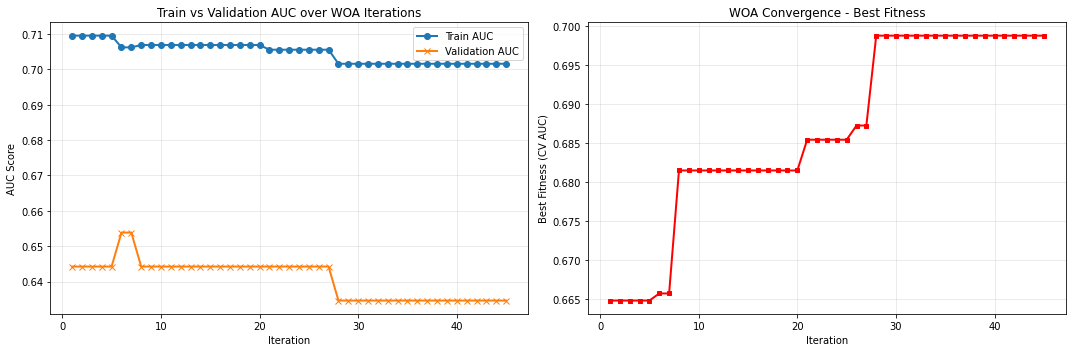

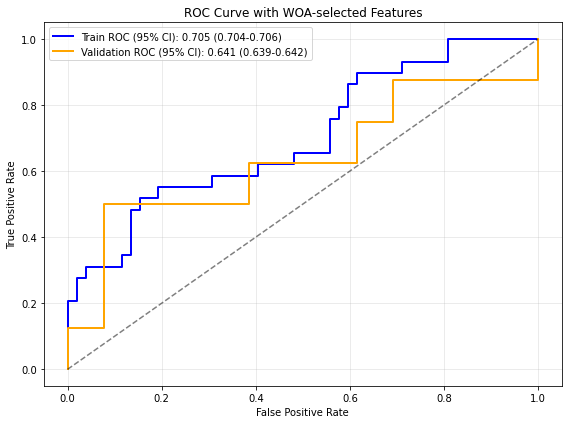

  LogisticRegression: Train AUC=0.7016, Val AUC=0.6346, Features selected=36

Processing GaussianNB with WOA on full feature set...
  Running WOA on 103 features...


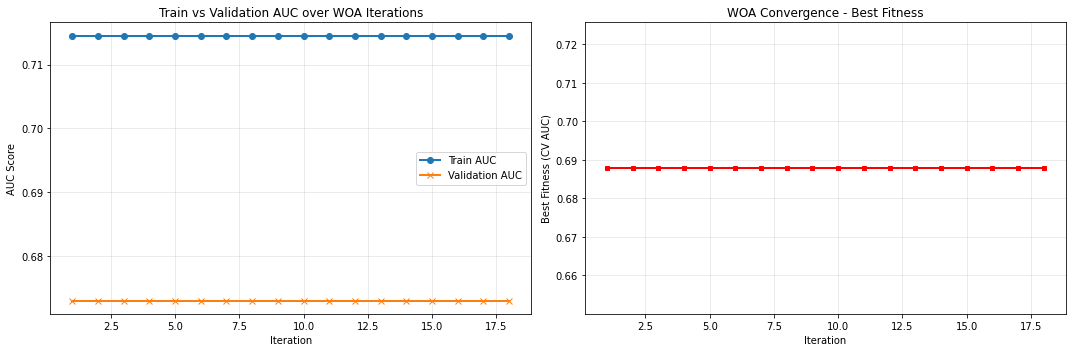

/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/scipy/stats/_bootstrap.py:106: RuntimeWarning: invalid value encountered in double_scalars
  alpha_1 = ndtr(z0_hat + num1/(1 - a_hat*num1))
/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/scipy/stats/_bootstrap.py:108: RuntimeWarning: invalid value encountered in double_scalars
  alpha_2 = ndtr(z0_hat + num2/(1 - a_hat*num2))
/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/scipy/stats/_bootstrap.py:100: RuntimeWarning: invalid value encountered in double_scalars
  a_hat = num / den


  GaussianNB: Train AUC=0.7145, Val AUC=0.6731, Features selected=51

Processing SVC with WOA on full feature set...
  Running WOA on 103 features...


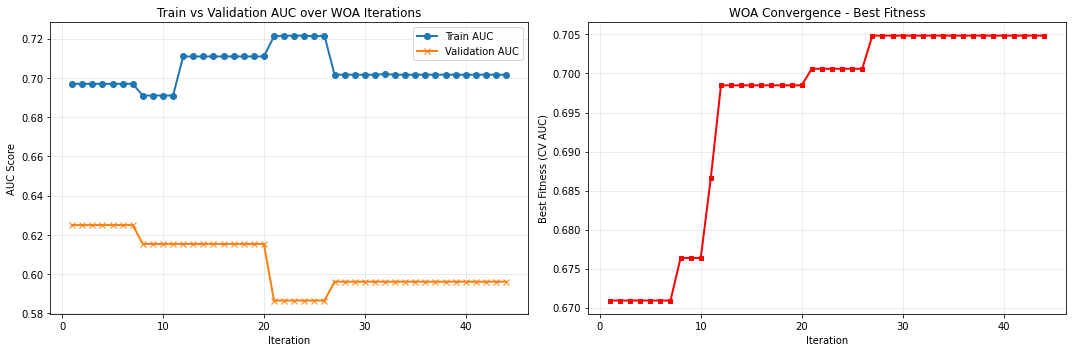

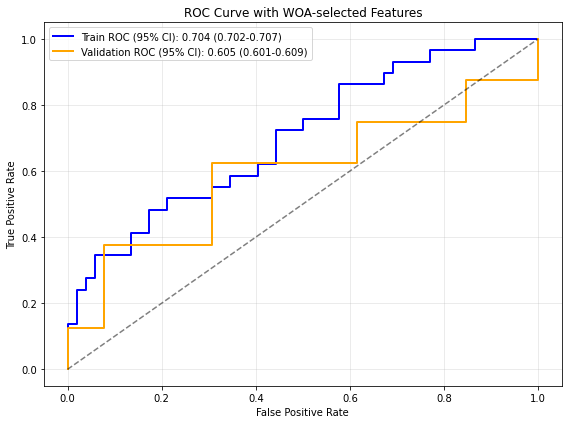

  SVC: Train AUC=0.7016, Val AUC=0.5962, Features selected=37

Processing SVC with WOA on full feature set...
  Running WOA on 103 features...


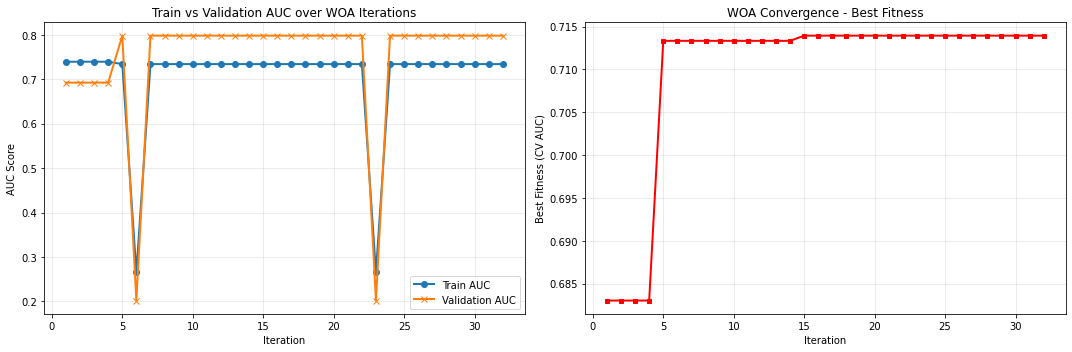

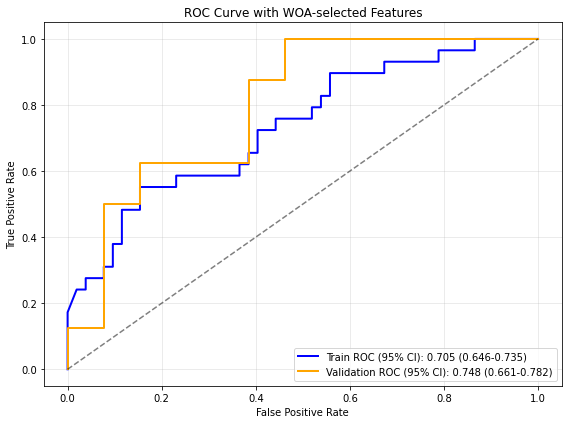

  SVC: Train AUC=0.7341, Val AUC=0.7981, Features selected=53

Processing DecisionTreeClassifier with WOA on full feature set...
  Running WOA on 103 features...


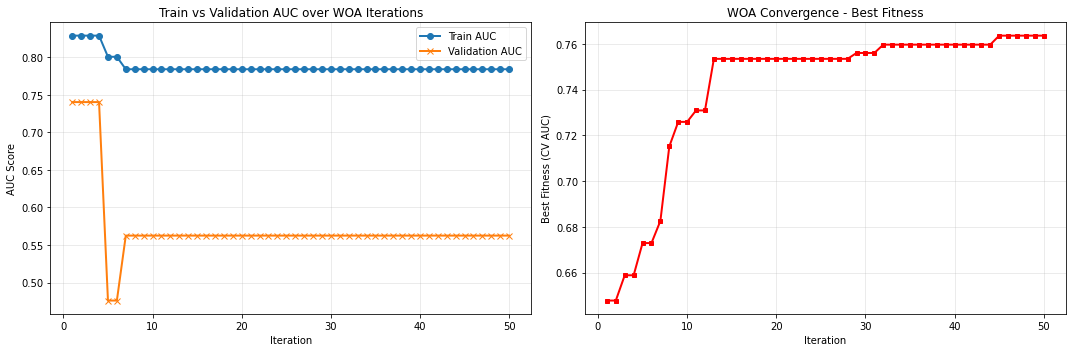

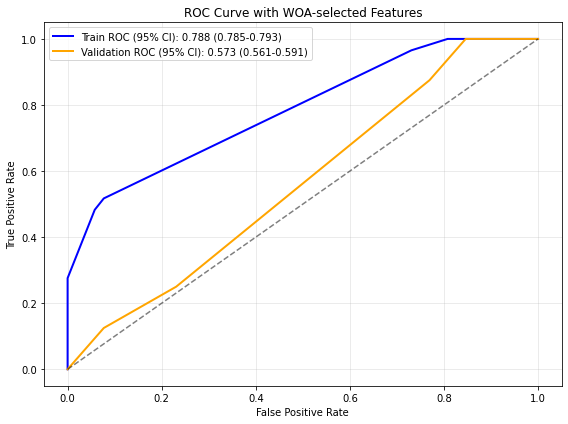

  DecisionTreeClassifier: Train AUC=0.7842, Val AUC=0.5625, Features selected=31

Processing RandomForestClassifier with WOA on full feature set...
  Running WOA on 103 features...


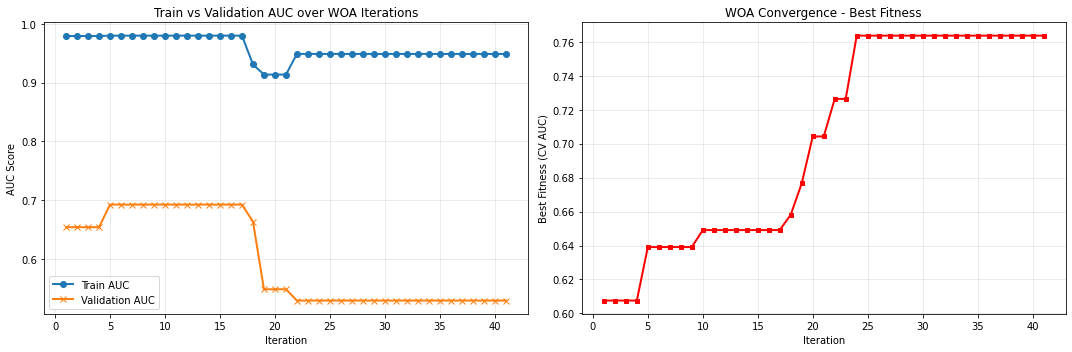

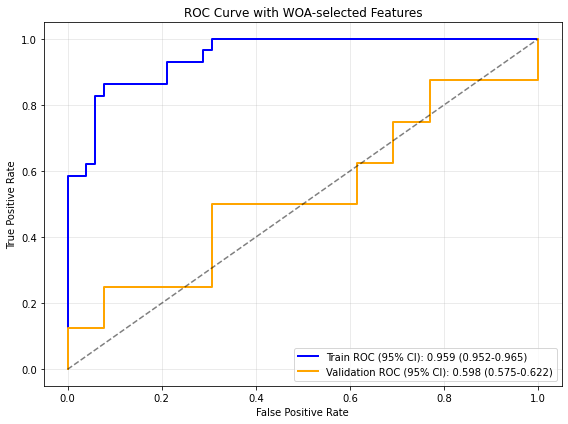

  RandomForestClassifier: Train AUC=0.9489, Val AUC=0.5288, Features selected=3

PROCESSING FOLD 2/5
Working with ALL 103 original features

Processing LogisticRegression with WOA on full feature set...
  Running WOA on 103 features...


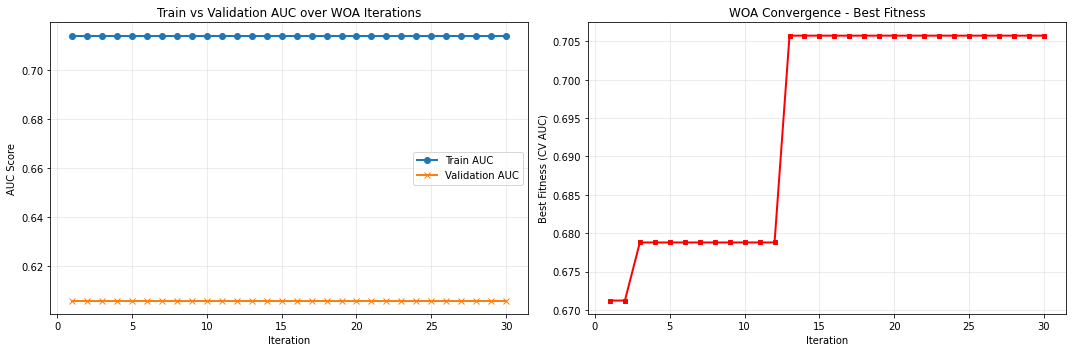

/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/scipy/stats/_bootstrap.py:106: RuntimeWarning: invalid value encountered in double_scalars
  alpha_1 = ndtr(z0_hat + num1/(1 - a_hat*num1))
/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/scipy/stats/_bootstrap.py:108: RuntimeWarning: invalid value encountered in double_scalars
  alpha_2 = ndtr(z0_hat + num2/(1 - a_hat*num2))


  LogisticRegression: Train AUC=0.7142, Val AUC=0.6058, Features selected=48

Processing GaussianNB with WOA on full feature set...
  Running WOA on 103 features...


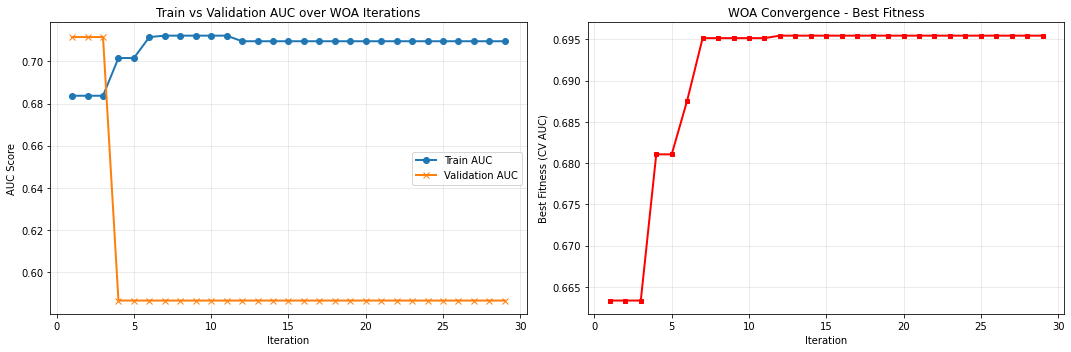

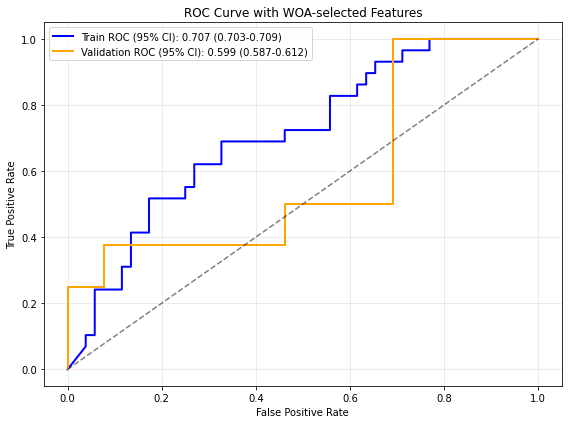

  GaussianNB: Train AUC=0.7095, Val AUC=0.5865, Features selected=31

Processing SVC with WOA on full feature set...
  Running WOA on 103 features...


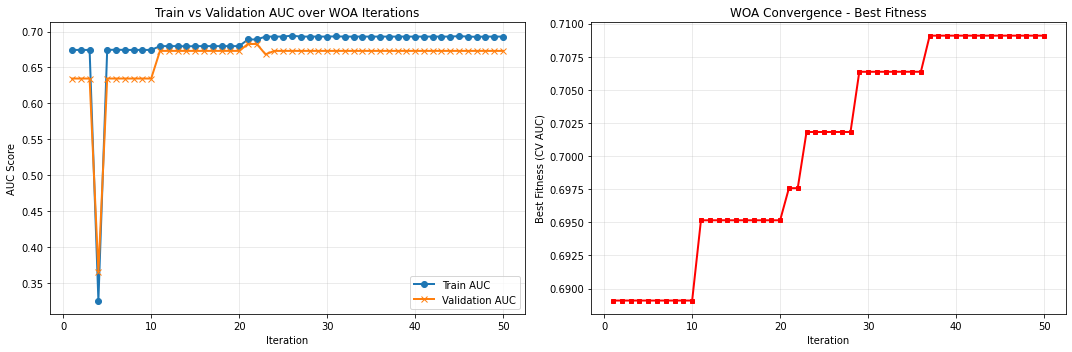

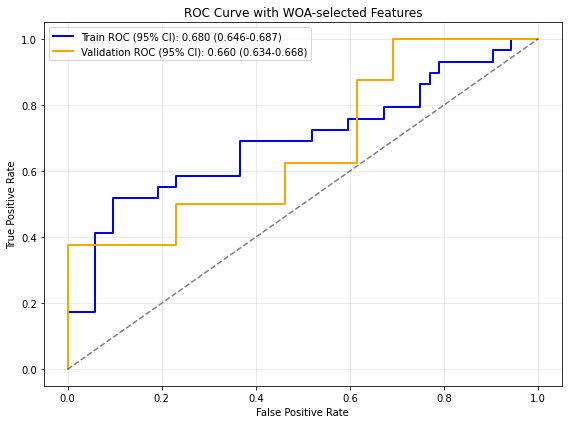

  SVC: Train AUC=0.6930, Val AUC=0.6683, Features selected=13

Processing SVC with WOA on full feature set...
  Running WOA on 103 features...


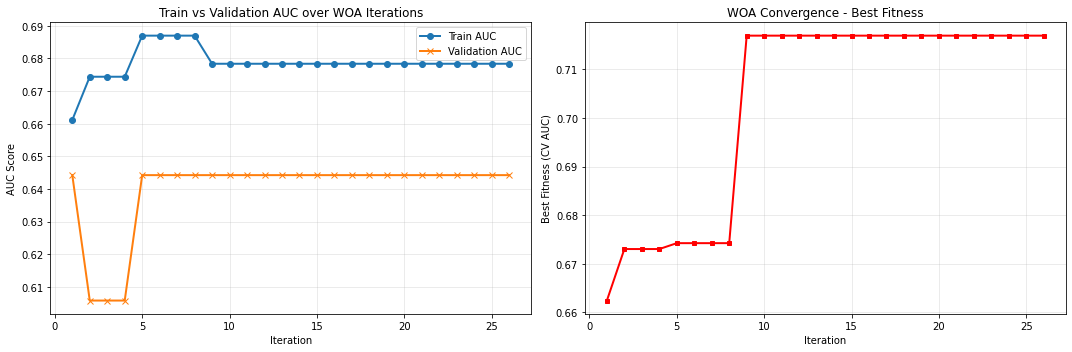

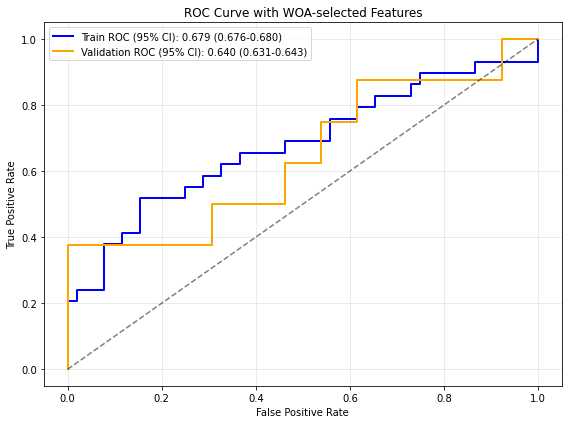

  SVC: Train AUC=0.6784, Val AUC=0.6442, Features selected=14

Processing DecisionTreeClassifier with WOA on full feature set...
  Running WOA on 103 features...


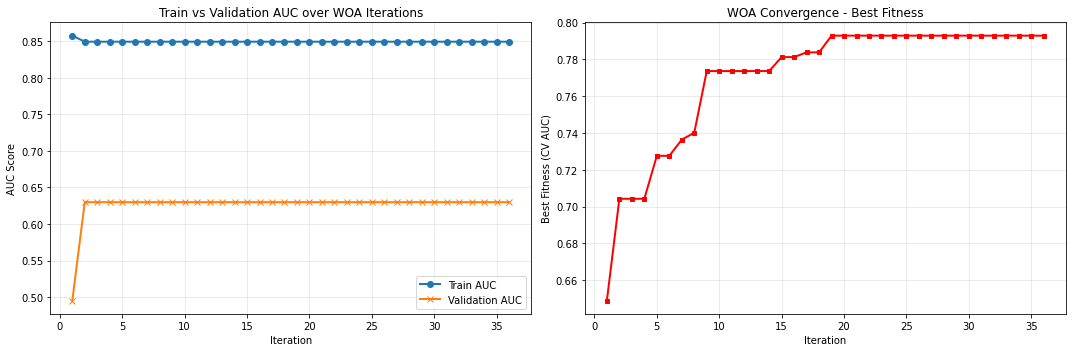

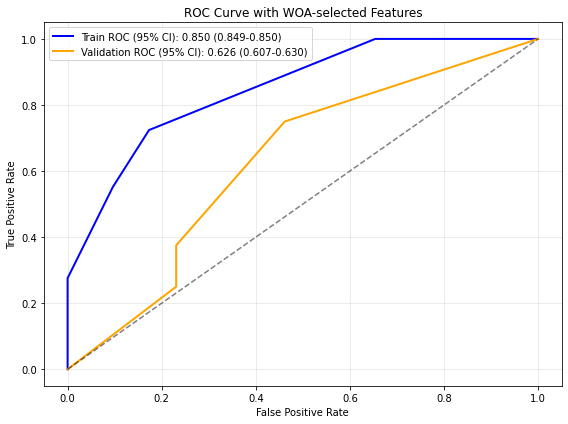

  DecisionTreeClassifier: Train AUC=0.8495, Val AUC=0.6298, Features selected=44

Processing RandomForestClassifier with WOA on full feature set...
  Running WOA on 103 features...


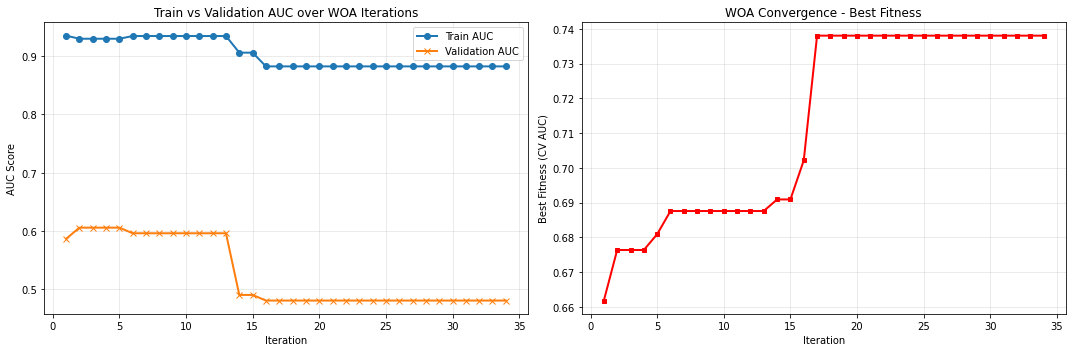

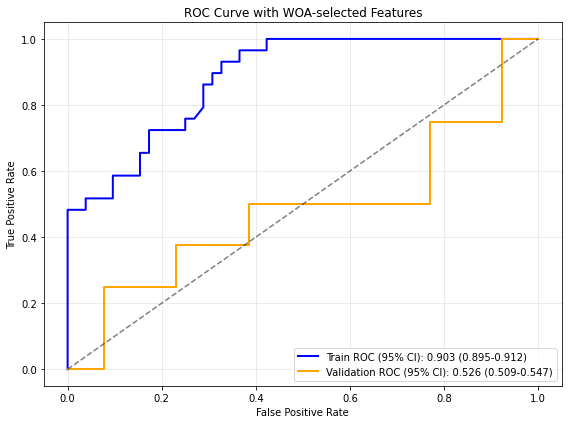

  RandomForestClassifier: Train AUC=0.8823, Val AUC=0.4808, Features selected=2

PROCESSING FOLD 3/5
Working with ALL 103 original features

Processing LogisticRegression with WOA on full feature set...
  Running WOA on 103 features...


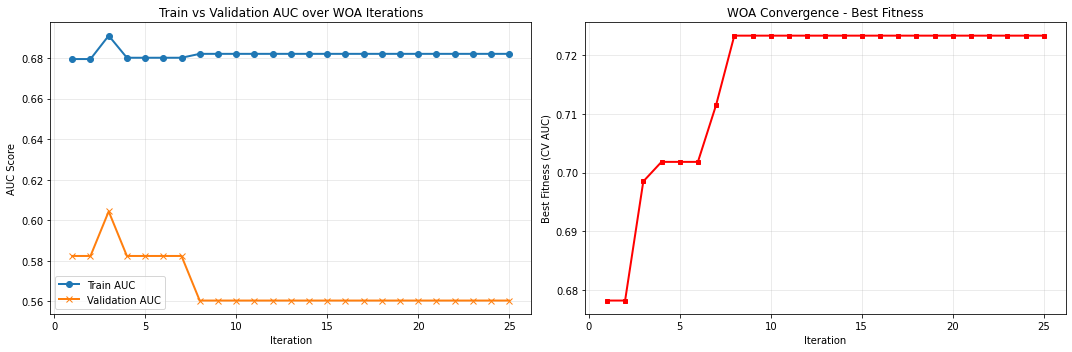

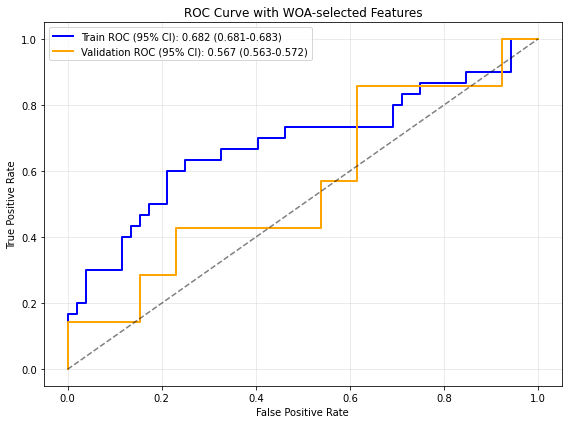

  LogisticRegression: Train AUC=0.6821, Val AUC=0.5604, Features selected=5

Processing GaussianNB with WOA on full feature set...
  Running WOA on 103 features...


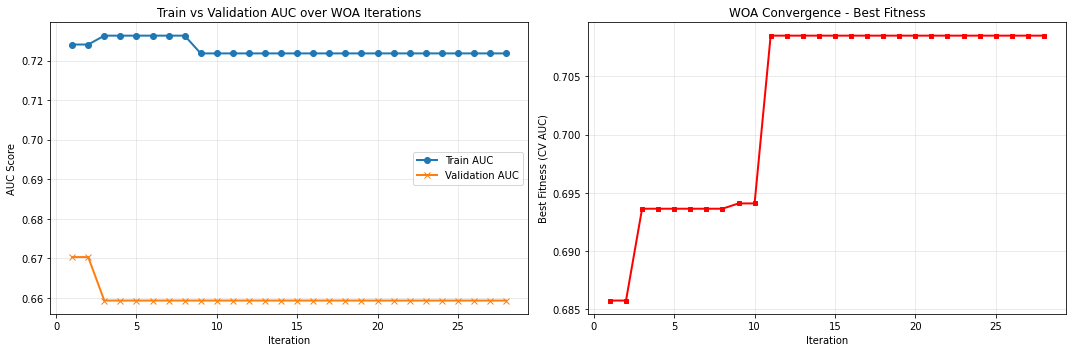

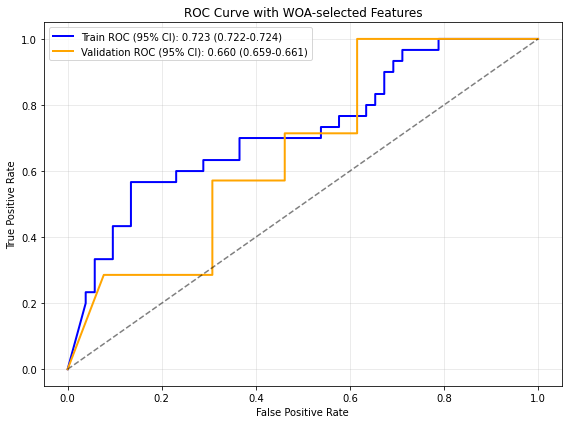

  GaussianNB: Train AUC=0.7218, Val AUC=0.6593, Features selected=57

Processing SVC with WOA on full feature set...
  Running WOA on 103 features...


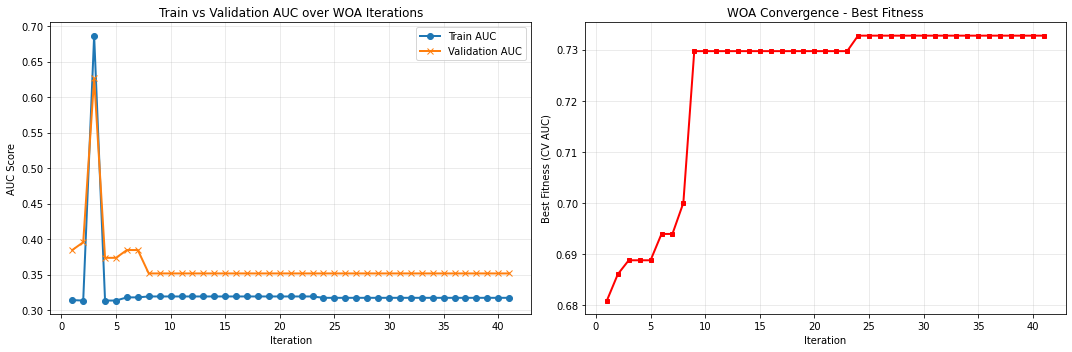

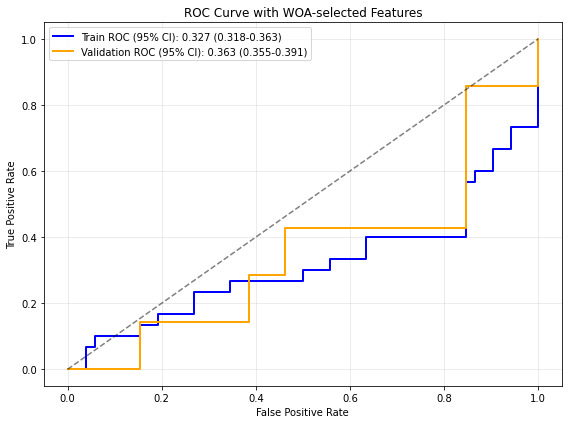

  SVC: Train AUC=0.3173, Val AUC=0.3516, Features selected=4

Processing SVC with WOA on full feature set...
  Running WOA on 103 features...


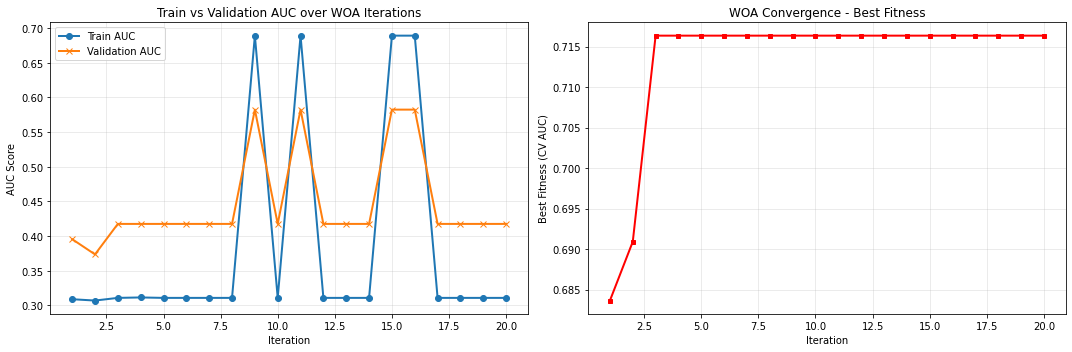

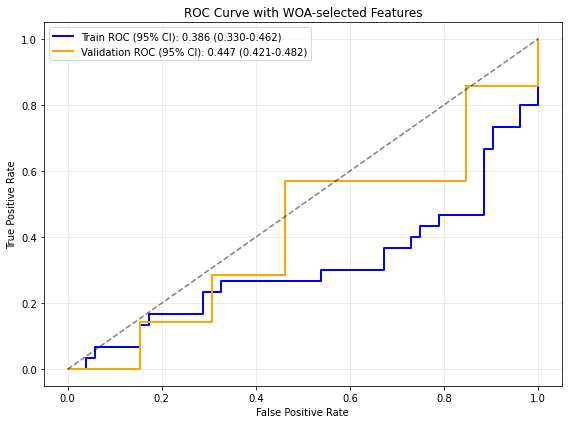

  SVC: Train AUC=0.3109, Val AUC=0.4176, Features selected=49

Processing DecisionTreeClassifier with WOA on full feature set...
  Running WOA on 103 features...


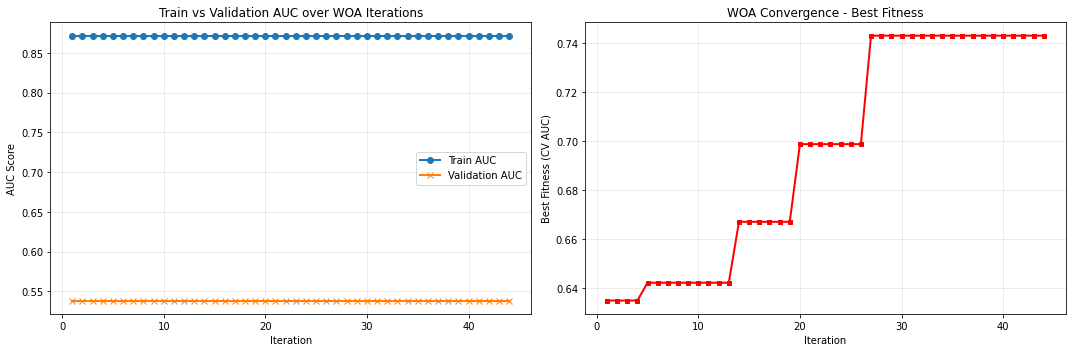

/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/scipy/stats/_bootstrap.py:100: RuntimeWarning: invalid value encountered in double_scalars
  a_hat = num / den
/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/scipy/stats/_bootstrap.py:106: RuntimeWarning: invalid value encountered in double_scalars
  alpha_1 = ndtr(z0_hat + num1/(1 - a_hat*num1))
/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/scipy/stats/_bootstrap.py:108: RuntimeWarning: invalid value encountered in double_scalars
  alpha_2 = ndtr(z0_hat + num2/(1 - a_hat*num2))


  DecisionTreeClassifier: Train AUC=0.8715, Val AUC=0.5385, Features selected=54

Processing RandomForestClassifier with WOA on full feature set...
  Running WOA on 103 features...


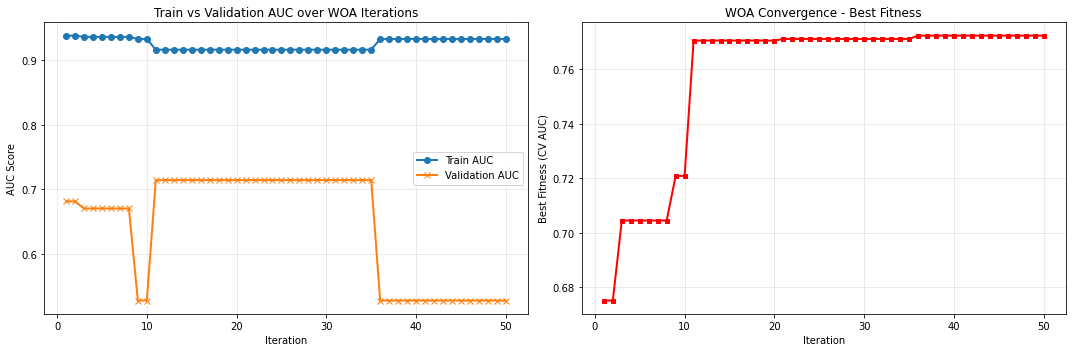

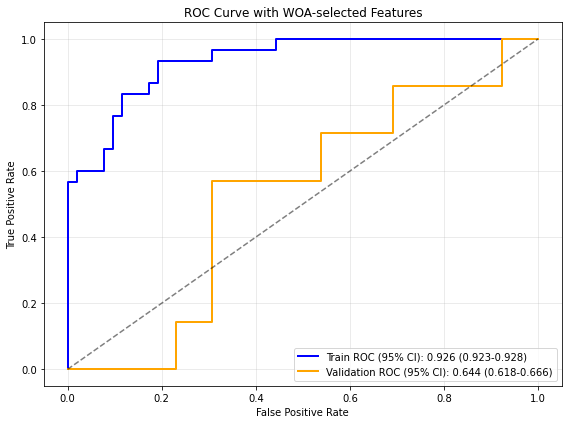

  RandomForestClassifier: Train AUC=0.9333, Val AUC=0.5275, Features selected=2

PROCESSING FOLD 4/5
Working with ALL 103 original features

Processing LogisticRegression with WOA on full feature set...
  Running WOA on 103 features...


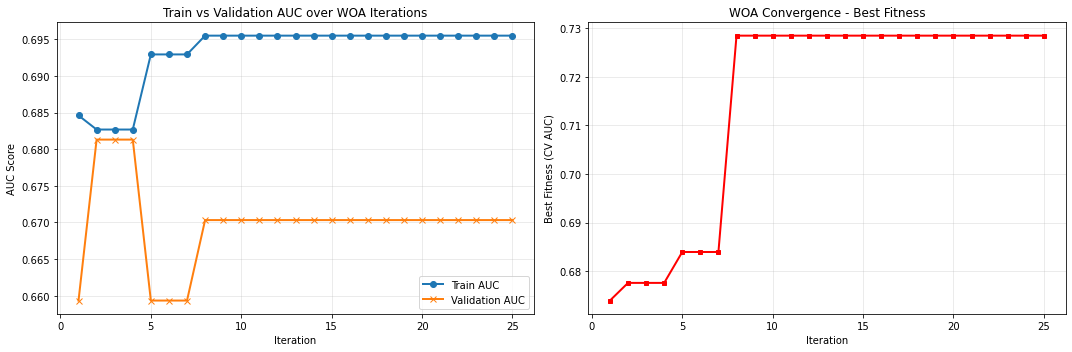

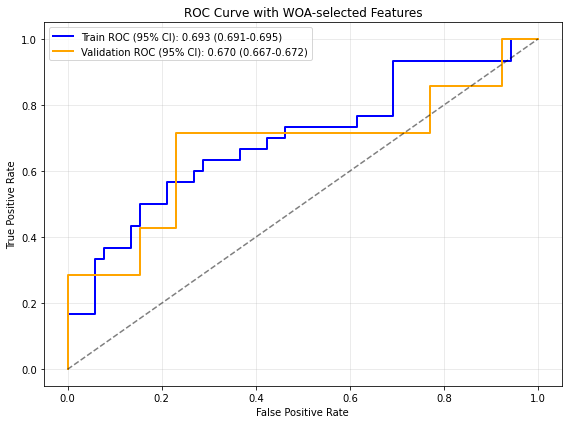

  LogisticRegression: Train AUC=0.6955, Val AUC=0.6703, Features selected=44

Processing GaussianNB with WOA on full feature set...
  Running WOA on 103 features...


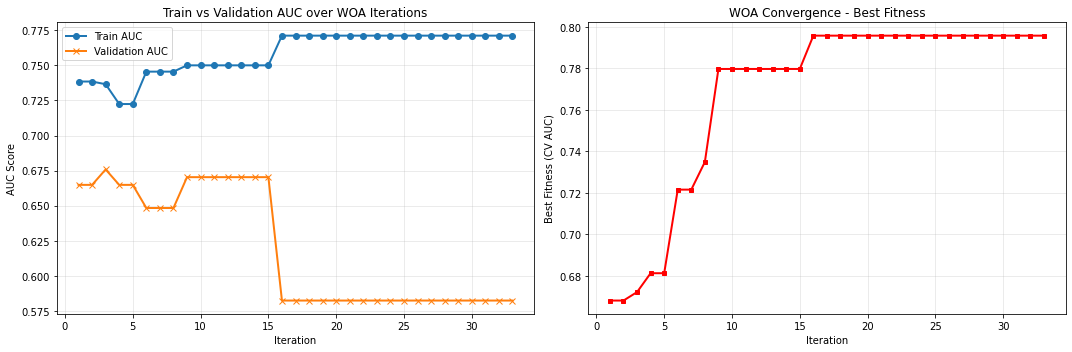

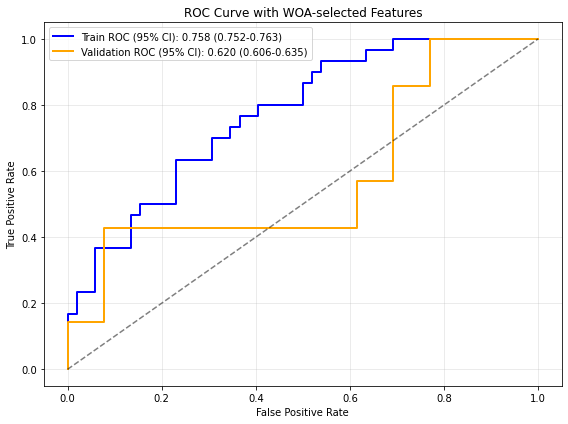

  GaussianNB: Train AUC=0.7712, Val AUC=0.5824, Features selected=4

Processing SVC with WOA on full feature set...
  Running WOA on 103 features...


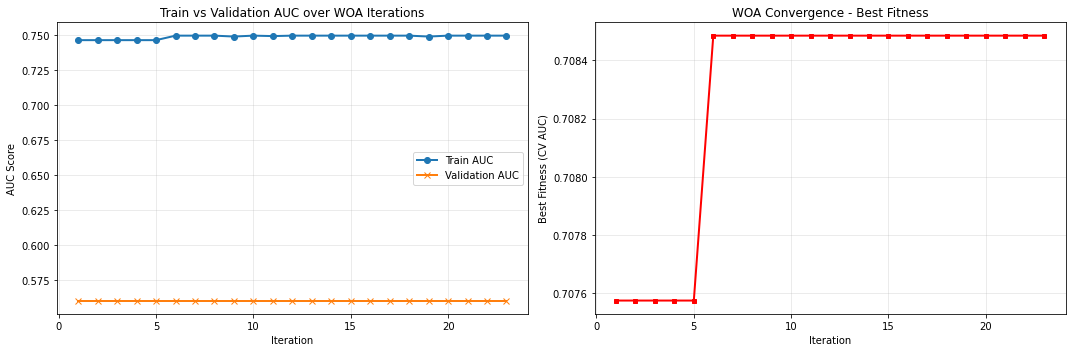

/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/scipy/stats/_bootstrap.py:100: RuntimeWarning: invalid value encountered in double_scalars
  a_hat = num / den


  SVC: Train AUC=0.7494, Val AUC=0.5604, Features selected=52

Processing SVC with WOA on full feature set...
  Running WOA on 103 features...


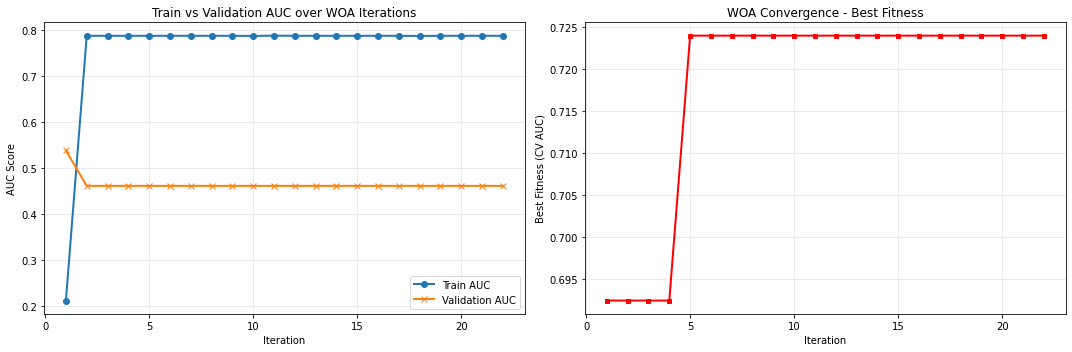

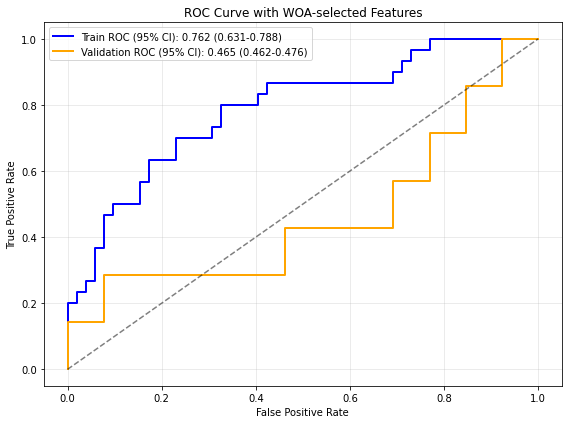

  SVC: Train AUC=0.7878, Val AUC=0.4615, Features selected=98

Processing DecisionTreeClassifier with WOA on full feature set...
  Running WOA on 103 features...


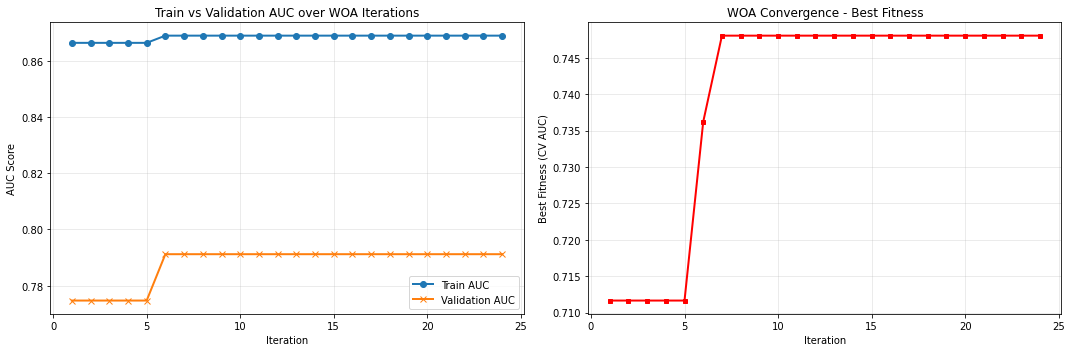

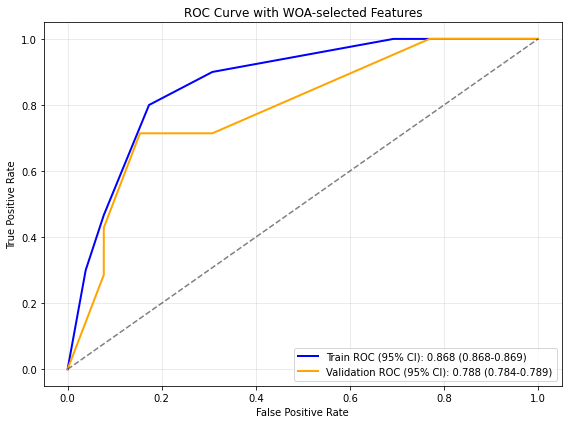

  DecisionTreeClassifier: Train AUC=0.8689, Val AUC=0.7912, Features selected=26

Processing RandomForestClassifier with WOA on full feature set...
  Running WOA on 103 features...


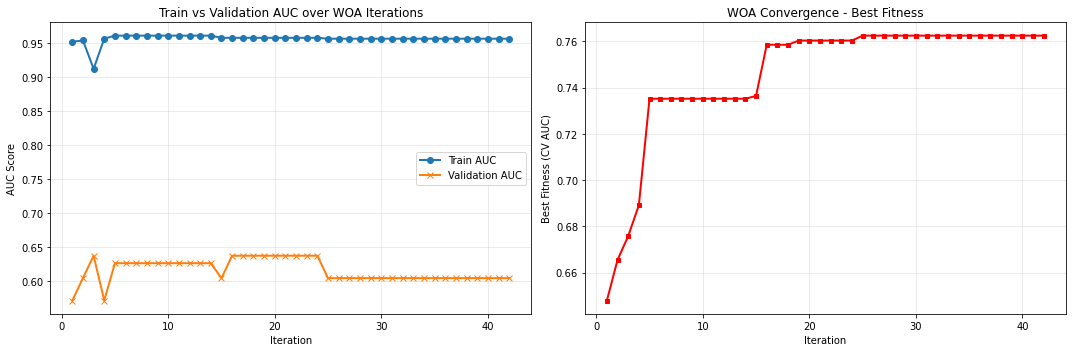

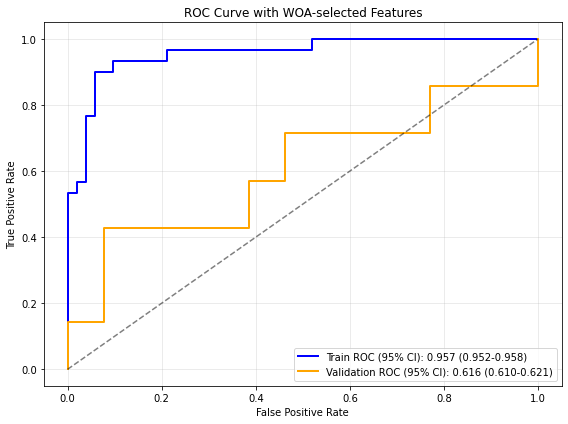

  RandomForestClassifier: Train AUC=0.9564, Val AUC=0.6044, Features selected=17

PROCESSING FOLD 5/5
Working with ALL 103 original features

Processing LogisticRegression with WOA on full feature set...
  Running WOA on 103 features...


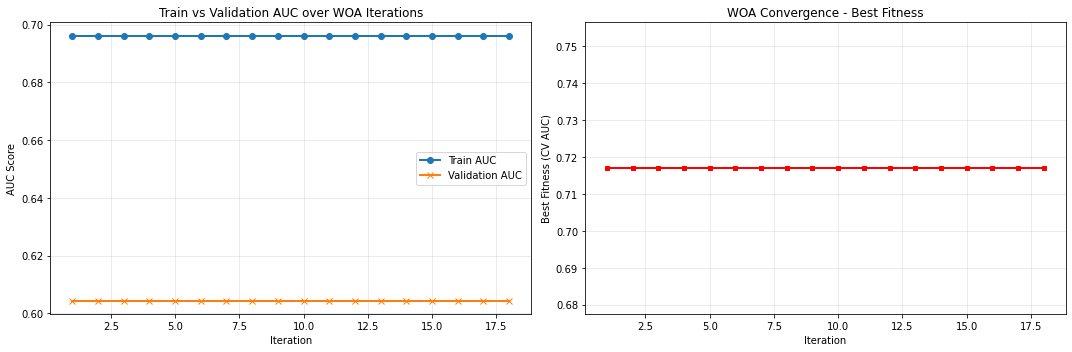

/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/scipy/stats/_bootstrap.py:100: RuntimeWarning: invalid value encountered in double_scalars
  a_hat = num / den


  LogisticRegression: Train AUC=0.6962, Val AUC=0.6044, Features selected=59

Processing GaussianNB with WOA on full feature set...
  Running WOA on 103 features...


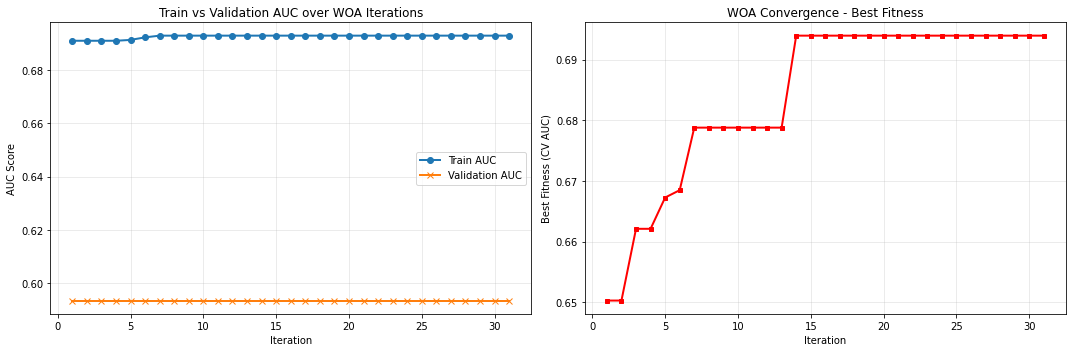

/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/scipy/stats/_bootstrap.py:106: RuntimeWarning: invalid value encountered in double_scalars
  alpha_1 = ndtr(z0_hat + num1/(1 - a_hat*num1))
/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/scipy/stats/_bootstrap.py:108: RuntimeWarning: invalid value encountered in double_scalars
  alpha_2 = ndtr(z0_hat + num2/(1 - a_hat*num2))


  GaussianNB: Train AUC=0.6929, Val AUC=0.5934, Features selected=55

Processing SVC with WOA on full feature set...
  Running WOA on 103 features...


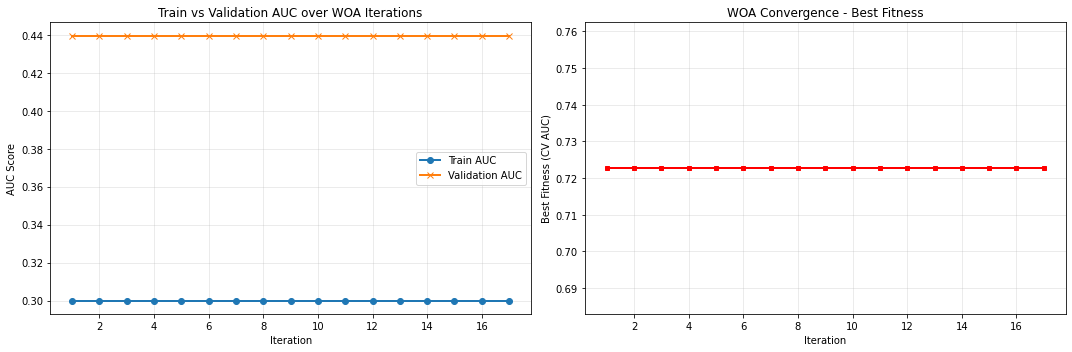

/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/scipy/stats/_bootstrap.py:100: RuntimeWarning: invalid value encountered in double_scalars
  a_hat = num / den


  SVC: Train AUC=0.3000, Val AUC=0.4396, Features selected=55

Processing SVC with WOA on full feature set...
  Running WOA on 103 features...


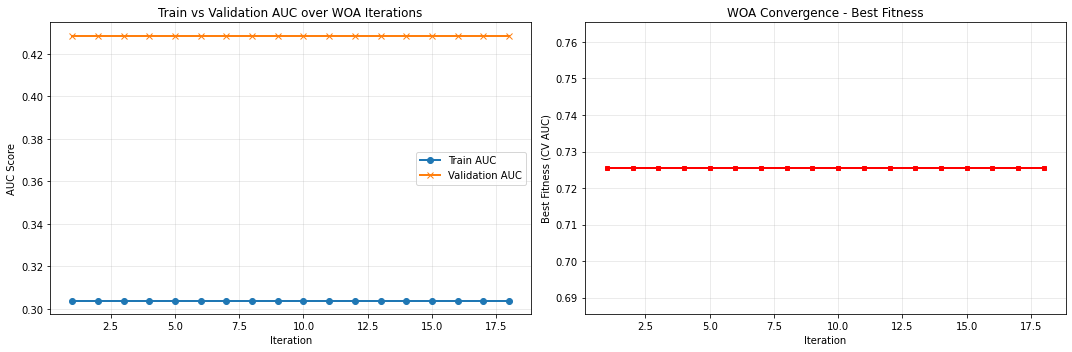

/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/scipy/stats/_bootstrap.py:100: RuntimeWarning: invalid value encountered in double_scalars
  a_hat = num / den


  SVC: Train AUC=0.3038, Val AUC=0.4286, Features selected=77

Processing DecisionTreeClassifier with WOA on full feature set...
  Running WOA on 103 features...


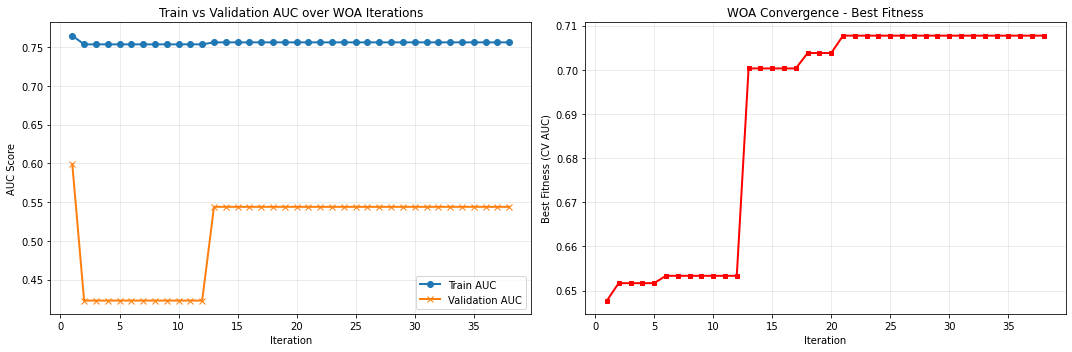

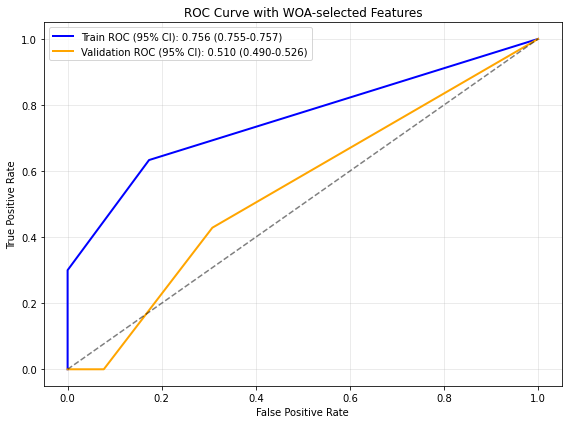

  DecisionTreeClassifier: Train AUC=0.7561, Val AUC=0.5440, Features selected=52

Processing RandomForestClassifier with WOA on full feature set...
  Running WOA on 103 features...


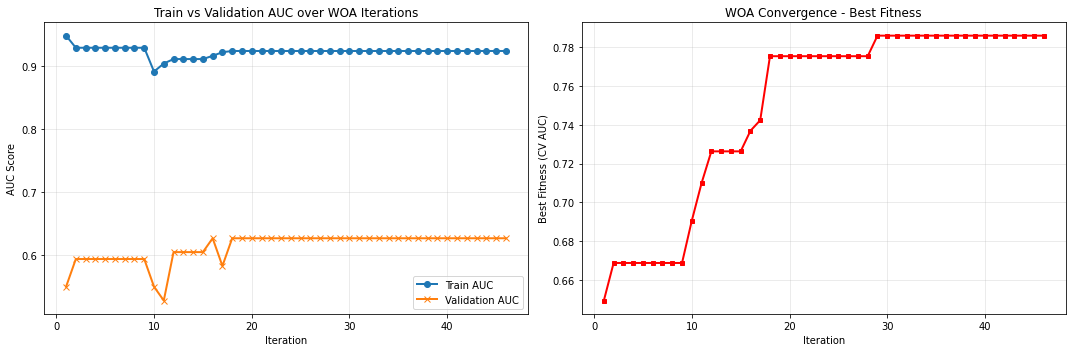

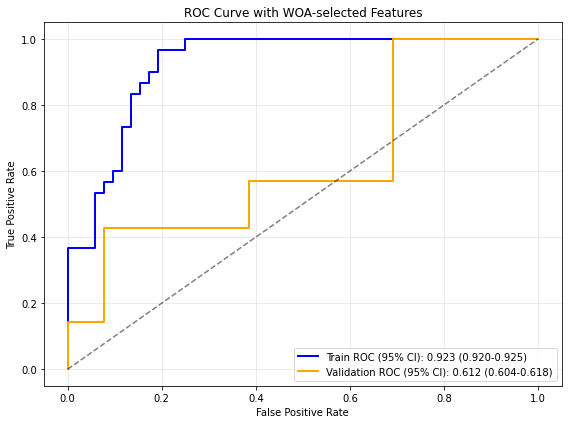

  RandomForestClassifier: Train AUC=0.9237, Val AUC=0.6264, Features selected=8

BUILDING CONSENSUS FEATURES FROM WOA SELECTIONS
LogisticRegression: 28 consensus features
GaussianNB: 32 consensus features
SVC: 94 consensus features
DecisionTreeClassifier: 34 consensus features
RandomForestClassifier: 3 consensus features

Final WOA consensus: 101 features
Consensus features: ['original_glrlm_RunPercentage', 'original_glrlm_ShortRunEmphasis', 'original_gldm_DependenceNonUniformity', 'original_gldm_SmallDependenceLowGrayLevelEmphasis', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum3DDiameter', 'original_gldm_DependenceVariance', 'original_firstorder_Mean', 'original_ngtdm_Busyness', 'original_glcm_Idm']...

FINAL EVALUATION ON HELD-OUT TEST SET
Final training set: (102, 101)
Final test set: (26, 101)

Final evaluation: LogisticRegression
Bootstrapped 95% CI for Final Model Test AUC: 0.6702 [0.5447, 0.7825] (valid reps = 1000)
Bootstrapped 95% CI for Final Model Test AUC: 

In [ ]:
def woa_only_main_pipeline():
    """
    WOA-ONLY feature selection pipeline (without LASSO pre-filtering).
    This version applies WOA directly to all original features for each classifier.
    
    Pipeline: Raw Data → 80/20 Split → 5-Fold CV → WOA → Consensus → Final Test
    
    Uses the same corrected WOA implementation to ensure methodological soundness.
    """
    
    print("="*80)
    print("WOA-ONLY RADIOMICS FEATURE SELECTION PIPELINE")
    print("="*80)
    
    # ===============================================================
    # 1) Load data and perform initial 80/20 split
    # ===============================================================
    print("\nStep 1: Loading data and creating train/test split...")
    
    radiomics_data, clinical_data = load_data()
    radiomics_cols = get_radiomics_columns(radiomics_data)
    X_raw = radiomics_data[radiomics_cols].values
    y = clinical_data["LocoRegeonalRecurrence"].values
    feature_names = radiomics_data[radiomics_cols].columns.tolist()

    print(f"Dataset: {len(X_raw)} samples, {X_raw.shape[1]} features")
    print(f"Class distribution: LRR={np.sum(y)} ({100*np.sum(y)/len(y):.1f}%), "
          f"Non-LRR={len(y)-np.sum(y)} ({100*(len(y)-np.sum(y))/len(y):.1f}%)")

    # Proper 80/20 split with stratification
    X_temp, X_test_raw, y_temp, y_test = train_test_split(
        X_raw, y, test_size=0.2, stratify=y, random_state=42
    )

    print(f"Training/Validation: {len(X_temp)} samples")
    print(f"Test (held-out): {len(X_test_raw)} samples")

    # ===============================================================
    # 2) 5-Fold CV with WOA-only feature selection
    # ===============================================================
    print(f"\nStep 2: 5-Fold Cross-Validation with WOA-only feature selection...")
    print("Note: WOA will work on all original features (no LASSO pre-filtering)")
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define classifiers
    classifiers = [
        LogisticRegression(max_iter=1000),
        GaussianNB(),
        SVC(kernel='linear', probability=True),
        SVC(kernel='rbf', probability=True),
        DecisionTreeClassifier(random_state=42),
        RandomForestClassifier(random_state=42, n_jobs=-1)
    ]

    # Store selected feature NAMES for proper consensus building
    fold_selected_features = {}  # classifier -> [fold_features_sets]
    classifier_fold_results = {}
    
    for clf in classifiers:
        clf_name = clf.__class__.__name__
        fold_selected_features[clf_name] = []
        classifier_fold_results[clf_name] = {
            'train_aucs': [], 'val_aucs': [], 'train_accs': [], 'val_accs': []
        }

    # Cross-validation loop
    for fold_id, (tr_idx, va_idx) in enumerate(skf.split(X_temp, y_temp), 1):
        print(f"\n{'='*60}")
        print(f"PROCESSING FOLD {fold_id}/5")
        print(f"{'='*60}")
        
        X_tr_raw, X_va_raw = X_temp[tr_idx], X_temp[va_idx]
        y_tr, y_va = y_temp[tr_idx], y_temp[va_idx]

        # STEP 1: Proper scaling (fit on train, transform both)
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr_raw)
        X_va_scaled = scaler.transform(X_va_raw)
        
        print(f"Working with ALL {X_tr_scaled.shape[1]} original features")

        # STEP 2: WOA feature selection per classifier (directly on all features)
        for clf in classifiers:
            clf_name = clf.__class__.__name__
            print(f"\nProcessing {clf_name} with WOA on full feature set...")
            
            try:
                # Hyperparameter tuning on full scaled feature set
                tuned_clf = get_tuned_model(clf, X_tr_scaled, y_tr)

                # WOA feature selection on ALL features (no LASSO pre-filtering)
                print(f"  Running WOA on {X_tr_scaled.shape[1]} features...")
                best_whale, train_auc_hist, val_auc_hist = run_woa(
                    X_tr_scaled, y_tr, X_va_scaled, y_va, tuned_clf, 
                    n_whales=30,  # Slightly more whales for larger search space
                    max_iter=50,  # More iterations for full feature space
                    verbose=False
                )

                # Get WOA-selected feature names
                woa_selected_indices = np.where(best_whale == 1)[0]
                woa_selected_feature_names = [feature_names[i] for i in woa_selected_indices]
                
                # Store selected feature names for this classifier and fold
                fold_selected_features[clf_name].append(set(woa_selected_feature_names))

                # Evaluate performance with WOA-selected features
                if len(woa_selected_indices) > 0:
                    X_tr_woa = X_tr_scaled[:, best_whale == 1]
                    X_va_woa = X_va_scaled[:, best_whale == 1]
                    
                    # Train final model and evaluate
                    final_model = make_pipeline(StandardScaler(), tuned_clf)
                    final_model.fit(X_tr_woa, y_tr)
                    
                    # Get predictions
                    if hasattr(final_model, 'predict_proba'):
                        y_tr_proba = final_model.predict_proba(X_tr_woa)[:, 1]
                        y_va_proba = final_model.predict_proba(X_va_woa)[:, 1]
                    else:
                        y_tr_proba = final_model.decision_function(X_tr_woa)
                        y_va_proba = final_model.decision_function(X_va_woa)
                    
                    y_tr_pred = final_model.predict(X_tr_woa)
                    y_va_pred = final_model.predict(X_va_woa)
                    
                    # Calculate metrics
                    train_auc = roc_auc_score(y_tr, y_tr_proba)
                    val_auc = roc_auc_score(y_va, y_va_proba)
                    train_acc = accuracy_score(y_tr, y_tr_pred)
                    val_acc = accuracy_score(y_va, y_va_pred)
                    
                    # Store results
                    classifier_fold_results[clf_name]['train_aucs'].append(train_auc)
                    classifier_fold_results[clf_name]['val_aucs'].append(val_auc)
                    classifier_fold_results[clf_name]['train_accs'].append(train_acc)
                    classifier_fold_results[clf_name]['val_accs'].append(val_acc)
                    
                    print(f"  {clf_name}: Train AUC={train_auc:.4f}, Val AUC={val_auc:.4f}, "
                          f"Features selected={len(woa_selected_indices)}")
                else:
                    print(f"  Warning: {clf_name} selected no features in fold {fold_id}")
                    
            except Exception as e:
                print(f"  Error processing {clf_name}: {e}")
                fold_selected_features[clf_name].append(set())

    # ===============================================================
    # 3) Build consensus features using the same method
    # ===============================================================
    print(f"\n{'='*60}")
    print("BUILDING CONSENSUS FEATURES FROM WOA SELECTIONS")
    print(f"{'='*60}")
    
    # Build consensus per classifier, then combine
    classifier_consensus_features = {}
    
    for clf_name in fold_selected_features:
        if len(fold_selected_features[clf_name]) == 0:
            classifier_consensus_features[clf_name] = set()
            continue
            
        # Get all unique features selected by this classifier across folds
        all_features_for_clf = set()
        for fold_features in fold_selected_features[clf_name]:
            all_features_for_clf.update(fold_features)
        
        # Count votes for each feature
        feature_votes = {}
        for feature in all_features_for_clf:
            votes = sum(1 for fold_features in fold_selected_features[clf_name] 
                       if feature in fold_features)
            feature_votes[feature] = votes
        
        # Select features with majority vote (>= 3 out of 5 folds)
        consensus_features_clf = {feature for feature, votes in feature_votes.items() 
                                 if votes >= 3}
        
        # Fallback: if no features meet majority threshold, use >= 2 votes
        if len(consensus_features_clf) == 0:
            consensus_features_clf = {feature for feature, votes in feature_votes.items() 
                                     if votes >= 2}
        
        # Final fallback: use union if still empty
        if len(consensus_features_clf) == 0:
            consensus_features_clf = all_features_for_clf
            
        classifier_consensus_features[clf_name] = consensus_features_clf
        print(f"{clf_name}: {len(consensus_features_clf)} consensus features")

    # FINAL CONSENSUS: Union of all classifier consensus features
    final_consensus_features = set()
    for clf_features in classifier_consensus_features.values():
        final_consensus_features.update(clf_features)
    
    # Convert back to indices for final evaluation
    consensus_feature_names = list(final_consensus_features)
    consensus_indices = [feature_names.index(fname) for fname in consensus_feature_names 
                        if fname in feature_names]
    
    print(f"\nFinal WOA consensus: {len(consensus_indices)} features")
    print(f"Consensus features: {consensus_feature_names[:10]}..." if len(consensus_feature_names) > 10 
          else f"Consensus features: {consensus_feature_names}")

    # ===============================================================
    # 4) Final evaluation on held-out test set
    # ===============================================================
    print(f"\n{'='*60}")
    print("FINAL EVALUATION ON HELD-OUT TEST SET")
    print(f"{'='*60}")
    
    if len(consensus_indices) == 0:
        print("ERROR: No consensus features found. Cannot proceed with final evaluation.")
        return
    
    # Apply final scaling and consensus feature selection
    scaler_final = StandardScaler()
    X_trval_scaled = scaler_final.fit_transform(X_temp)
    X_test_scaled = scaler_final.transform(X_test_raw)
    
    # Select WOA consensus features
    X_trval_final = X_trval_scaled[:, consensus_indices]
    X_test_final = X_test_scaled[:, consensus_indices]
    
    print(f"Final training set: {X_trval_final.shape}")
    print(f"Final test set: {X_test_final.shape}")

    # Final evaluation per classifier
    final_results = {}
    
    for clf in classifiers:
        clf_name = clf.__class__.__name__
        print(f"\nFinal evaluation: {clf_name}")
        
        try:
            # Retune on full 80% with WOA consensus features
            tuned_clf_final = get_tuned_model(clf, X_trval_final, y_temp)
            tuned_clf_final.fit(X_trval_final, y_temp)

            # Training performance (80% data)
            if hasattr(tuned_clf_final, "predict_proba"):
                y_train_proba = tuned_clf_final.predict_proba(X_trval_final)[:, 1]
            else:
                y_train_proba = tuned_clf_final.decision_function(X_trval_final)
            
            y_train_pred = tuned_clf_final.predict(X_trval_final)
            train_auc = roc_auc_score(y_temp, y_train_proba)
            train_acc = accuracy_score(y_temp, y_train_pred)

            # Test performance (20% held-out data)
            if hasattr(tuned_clf_final, "predict_proba"):
                y_test_proba = tuned_clf_final.predict_proba(X_test_final)[:, 1]
            else:
                y_test_proba = tuned_clf_final.decision_function(X_test_final)
            
            y_test_pred = tuned_clf_final.predict(X_test_final)
            test_auc = roc_auc_score(y_test, y_test_proba)
            test_acc = accuracy_score(y_test, y_test_pred)

            # Bootstrap confidence intervals
            train_mean_auc, train_lower, train_upper, train_valid = bootstrap_final_model_auc_ci(
                y_temp, y_train_proba, n_bootstrap=1000
            )
            
            test_mean_auc, test_lower, test_upper, test_valid = bootstrap_final_model_auc_ci(
                y_test, y_test_proba, n_bootstrap=1000
            )

            # Store results
            final_results[clf_name] = {
                'train_auc': train_auc,
                'train_acc': train_acc,
                'test_auc': test_auc,
                'test_acc': test_acc,
                'train_ci_lower': train_lower,
                'train_ci_upper': train_upper,
                'test_ci_lower': test_lower,
                'test_ci_upper': test_upper
            }
            
        except Exception as e:
            print(f"Error evaluating {clf_name}: {e}")

    # ===============================================================
    # 5) COMPREHENSIVE RESULTS SUMMARY
    # ===============================================================
    print(f"\n{'='*80}")
    print("WOA-ONLY PIPELINE PERFORMANCE SUMMARY")
    print(f"{'='*80}")
    
    print(f"\nDATASET SUMMARY:")
    print(f"- Total samples: {len(X_raw)} (Train/Val: {len(X_temp)}, Test: {len(X_test_raw)})")
    print(f"- Original features: {X_raw.shape[1]}")
    print(f"- WOA consensus features: {len(consensus_indices)}")
    print(f"- Feature reduction: {X_raw.shape[1]} → {len(consensus_indices)} "
          f"({100*len(consensus_indices)/X_raw.shape[1]:.1f}%)")
    print(f"- Class distribution: LRR={np.sum(y)} ({100*np.sum(y)/len(y):.1f}%)")

    # Cross-validation performance summary
    print(f"\nCROSS-VALIDATION PERFORMANCE (5-Fold, Mean ± Std):")
    print("-" * 80)
    print(f"{'Classifier':<25} {'Train AUC':<15} {'Val AUC':<15} {'Train Acc':<15} {'Val Acc':<15}")
    print("-" * 80)
    
    for clf_name, results in classifier_fold_results.items():
        if results['train_aucs']:
            train_auc_mean = np.mean(results['train_aucs'])
            train_auc_std = np.std(results['train_aucs'])
            val_auc_mean = np.mean(results['val_aucs'])
            val_auc_std = np.std(results['val_aucs'])
            train_acc_mean = np.mean(results['train_accs'])
            train_acc_std = np.std(results['train_accs'])
            val_acc_mean = np.mean(results['val_aucs'])
            val_acc_std = np.std(results['val_accs'])
            
            print(f"{clf_name:<25} {train_auc_mean:.3f}±{train_auc_std:.3f}     "
                  f"{val_auc_mean:.3f}±{val_auc_std:.3f}     "
                  f"{train_acc_mean:.3f}±{train_acc_std:.3f}     "
                  f"{val_acc_mean:.3f}±{val_acc_std:.3f}")

    # Final test performance
    print(f"\nFINAL PERFORMANCE WITH 95% BOOTSTRAP CONFIDENCE INTERVALS:")
    print("-" * 100)
    print(f"{'Classifier':<25} {'Train AUC [95% CI]':<25} {'Test AUC [95% CI]':<25} {'Test Acc':<10}")
    print("-" * 100)
    
    for clf_name, results in final_results.items():
        train_auc = results['train_auc']
        train_lower = results['train_ci_lower']
        train_upper = results['train_ci_upper']
        test_auc = results['test_auc']
        test_lower = results['test_ci_lower']
        test_upper = results['test_ci_upper']
        test_acc = results['test_acc']

        print(f"{clf_name:<25} {train_auc:.3f} [{train_lower:.3f},{train_upper:.3f}]   "
              f"{test_auc:.3f} [{test_lower:.3f},{test_upper:.3f}]   {test_acc:.3f}")

    # Best performer and comparison insights
    if final_results:
        best_clf = max(final_results.keys(), key=lambda x: final_results[x]['test_auc'])
        best_test_auc = final_results[best_clf]['test_auc']
        best_test_acc = final_results[best_clf]['test_acc']
        
        print(f"\nBest WOA-Only Performance: {best_clf}")
        print(f"Test AUC: {best_test_auc:.4f}, Test Accuracy: {best_test_acc:.4f}")
        
        # Calculate average feature reduction
        avg_features_per_classifier = np.mean([len(features) for features in classifier_consensus_features.values() if features])
        print(f"Average features per classifier: {avg_features_per_classifier:.1f}")

    print(f"\n{'='*80}")
    print("WOA-ONLY PIPELINE COMPLETE")
    print("Compare these results with LASSO+WOA to evaluate the impact of pre-filtering")
    print(f"{'='*80}")
    
    return final_results, consensus_feature_names, classifier_fold_results


# Run the WOA-only pipeline
if __name__ == "__main__":
    woa_results, woa_consensus_features, woa_cv_results = woa_only_main_pipeline()

---